In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

In [43]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB16 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
dataset_name = 'meld'
experiment_prefix = "scb16"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run0/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}4.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 2

{'name': 'meld', 'dataset_class': 'WaveformDataset', 'root': 'meld/', 'audio_dir': 'full_release/', 'feature_dir': 'features_4balanced/', 'label_name': 'label_emotion', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': [0, 1, 2, 3], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [8]:
in_channels = 1
out_channels = 8
embedding_dim = 1023
num_embeddings = 384
commitment_cost = 0.25
learning_rate = 1e-4
num_tokens = 256
num_classes = 4

In [9]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [10]:
codebook_pretrained_path = f'../scb7_models/meld/codebook.epoch=75.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [11]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [44]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [13]:
trainer.setup(model=model, lr=learning_rate)

In [14]:
trainer.fit(n_epoch=70, self_supervised=False, train_task='embedding', test_n_epoch=10)

  1%|▌                                                                             | 0.47632390025215354/70 [10:48<1423:50:34, 73727.90s/it]

Epoch: 1	Loss: 1.653 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.653]	Val_acc: 198/340 (58.24%)

Saved new best val model: ../scb16_models/meld/run0/model.epoch=1.step=1275.loss=1.653.val_acc=0.582.pt


  1%|█                                                                              | 0.9523676099747226/70 [21:38<1394:42:25, 72717.13s/it]

Epoch: 1	Loss: 0.629 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.629]	Val_acc: 198/340 (58.24%)



  2%|█▋                                                                                 | 1.4286915102270215/70 [29:13<18:08:08, 952.12s/it]

Correct: 937/1700 (0.5512)
Saved new best test model: ../scb16_models/meld/run0/model.epoch=1.step=2549.test_acc=0.5512.pt
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.5512, device='cuda:0'),
 'f1s_unweighted': tensor(0.1777, device='cuda:0'),
 'f1s_weighted': tensor(0.3917, device='cuda:0'),
 'rocauc': tensor(0.5436, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.3038, device='cuda:0')}
{'acc_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.6269, 0.5568, 0.4411, 0.5497], device='cuda:0')}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]], device='cuda:0')


  3%|██▏                                                                            | 1.9050154104793393/70 [40:12<1389:08:22, 73440.10s/it]

Epoch: 2	Loss: 2.037 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.037]	Val_acc: 198/340 (58.24%)



  3%|██▋                                                                            | 2.3810591202020968/70 [51:16<1369:46:19, 72926.01s/it]

Epoch: 2	Loss: 1.134 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.134]	Val_acc: 198/340 (58.24%)



  4%|███▏                                                                         | 2.8573830204544146/70 [1:02:24<1370:37:35, 73489.17s/it]

Epoch: 3	Loss: 2.131 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.131]	Val_acc: 198/340 (58.24%)



  5%|███▋                                                                         | 3.3334267301771723/70 [1:13:26<1364:36:01, 73688.53s/it]

Epoch: 3	Loss: 0.626 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.626]	Val_acc: 198/340 (58.24%)



  5%|████▎                                                                          | 3.80975063042949/70 [1:24:39<1360:46:55, 74011.13s/it]

Epoch: 4	Loss: 1.360 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.360]	Val_acc: 189/340 (55.59%)



  6%|████▊                                                                         | 4.285794340152248/70 [1:35:49<1373:02:44, 75219.11s/it]

Epoch: 4	Loss: 2.424 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.424]	Val_acc: 198/340 (58.24%)



  7%|█████▎                                                                        | 4.762118240404566/70 [1:47:06<1347:21:17, 74350.63s/it]

Epoch: 5	Loss: 1.776 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.776]	Val_acc: 198/340 (58.24%)



  7%|█████▊                                                                        | 5.238161950127323/70 [1:58:16<1346:15:50, 74836.52s/it]

Epoch: 5	Loss: 1.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.080]	Val_acc: 198/340 (58.24%)



  8%|██████▎                                                                       | 5.714485850379641/70 [2:09:32<1322:13:34, 74044.91s/it]

Epoch: 6	Loss: 1.029 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.029]	Val_acc: 197/340 (57.94%)



  9%|██████▉                                                                       | 6.190529560102399/70 [2:20:44<1317:17:18, 74318.73s/it]

Epoch: 6	Loss: 0.898 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.898]	Val_acc: 194/340 (57.06%)



 10%|███████▍                                                                      | 6.666853460354717/70 [2:31:57<1283:56:19, 72982.00s/it]

Epoch: 7	Loss: 1.658 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.658]	Val_acc: 185/340 (54.41%)



 10%|███████▉                                                                      | 7.142897170077474/70 [2:43:05<1299:02:24, 74399.61s/it]

Epoch: 7	Loss: 0.387 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.387]	Val_acc: 197/340 (57.94%)



 11%|████████▍                                                                     | 7.619221070329792/70 [2:54:22<1293:46:50, 74664.20s/it]

Epoch: 8	Loss: 0.645 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.645]	Val_acc: 195/340 (57.35%)



 12%|█████████                                                                     | 8.095264780052549/70 [3:05:38<1294:17:32, 75268.12s/it]

Epoch: 8	Loss: 0.506 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.506]	Val_acc: 194/340 (57.06%)



 12%|█████████▌                                                                    | 8.571588680304867/70 [3:17:01<1280:00:06, 75014.26s/it]

Epoch: 9	Loss: 1.073 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.073]	Val_acc: 192/340 (56.47%)



 13%|██████████                                                                    | 9.047632390027625/70 [3:28:18<1263:32:07, 74627.57s/it]

Epoch: 9	Loss: 2.355 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.355]	Val_acc: 186/340 (54.71%)



 14%|██████████▌                                                                   | 9.523956290279942/70 [3:39:40<1248:53:12, 74343.37s/it]

Epoch: 10	Loss: 0.441 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.441]	Val_acc: 194/340 (57.06%)



 14%|███████████▎                                                                   | 10.0000000000027/70 [3:51:00<1245:49:21, 74749.35s/it]

Epoch: 10	Loss: 0.261 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.261]	Val_acc: 180/340 (52.94%)



 15%|███████████▌                                                                 | 10.476323900255018/70 [4:02:27<1266:13:26, 76581.40s/it]

Epoch: 11	Loss: 1.251 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.251]	Val_acc: 174/340 (51.18%)



 16%|████████████                                                                 | 10.952367609977776/70 [4:13:49<1229:24:17, 74954.02s/it]

Epoch: 11	Loss: 0.283 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.283]	Val_acc: 192/340 (56.47%)



 16%|█████████████                                                                   | 11.428691510230093/70 [4:21:50<16:25:36, 1009.65s/it]

Correct: 918/1700 (0.5400)
{'acc_unweighted': tensor(0.2760, device='cuda:0'),
 'acc_weighted': tensor(0.5400, device='cuda:0'),
 'f1s_unweighted': tensor(0.2304, device='cuda:0'),
 'f1s_weighted': tensor(0.4194, device='cuda:0'),
 'rocauc': tensor(0.5558, device='cuda:0'),
 'uar': tensor(0.2760, device='cuda:0'),
 'wap': tensor(0.3562, device='cuda:0')}
{'acc_detail': tensor([0.1712, 0.9328, 0.0000, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.2211, 0.7003, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.3121, 0.5606, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.1712, 0.9328, 0.0000, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.6125, 0.5653, 0.5042, 0.5413], device='cuda:0')}
tensor([[ 44, 213,   0,   0],
        [ 63, 874,   0,   0],
        [  7, 154,   0,   0],
        [ 27, 318,   0,   0]], device='cuda:0')


 17%|█████████████                                                                | 11.905015410482411/70 [4:33:12<1201:33:46, 74457.82s/it]

Epoch: 12	Loss: 0.229 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.229]	Val_acc: 172/340 (50.59%)



 18%|█████████████▌                                                               | 12.381059120205169/70 [4:44:31<1207:15:03, 75428.39s/it]

Epoch: 12	Loss: 0.411 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.411]	Val_acc: 175/340 (51.47%)



 18%|██████████████▏                                                              | 12.857383020457487/70 [4:55:56<1194:17:01, 75240.20s/it]

Epoch: 13	Loss: 0.839 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.839]	Val_acc: 138/340 (40.59%)



 19%|██████████████▋                                                              | 13.333426730180244/70 [5:07:20<1202:34:38, 76399.16s/it]

Epoch: 13	Loss: 0.154 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.154]	Val_acc: 187/340 (55.00%)



 20%|███████████████▏                                                             | 13.809750630432562/70 [5:18:51<1174:24:53, 75242.48s/it]

Epoch: 14	Loss: 0.940 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.940]	Val_acc: 173/340 (50.88%)



 20%|███████████████▉                                                              | 14.28579434015532/70 [5:30:16<1173:28:09, 75824.28s/it]

Epoch: 14	Loss: 0.674 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.674]	Val_acc: 172/340 (50.59%)



 21%|████████████████▏                                                            | 14.762118240407638/70 [5:41:46<1179:15:13, 76855.12s/it]

Epoch: 15	Loss: 0.083 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.083]	Val_acc: 157/340 (46.18%)



 22%|████████████████▊                                                            | 15.238161950130396/70 [5:53:17<1162:45:17, 76438.59s/it]

Epoch: 15	Loss: 0.360 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.360]	Val_acc: 154/340 (45.29%)



 22%|█████████████████▎                                                           | 15.714485850382713/70 [6:04:52<1156:01:38, 76663.15s/it]

Epoch: 16	Loss: 0.539 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.539]	Val_acc: 166/340 (48.82%)



 23%|█████████████████▊                                                           | 16.190529560104263/70 [6:16:23<1148:30:45, 76838.61s/it]

Epoch: 16	Loss: 0.310 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.310]	Val_acc: 118/340 (34.71%)



 24%|██████████████████▌                                                           | 16.66685346035356/70 [6:27:58<1132:52:06, 76468.90s/it]

Epoch: 17	Loss: 1.651 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.651]	Val_acc: 151/340 (44.41%)



 24%|███████████████████▎                                                           | 17.1428971700733/70 [6:39:32<1112:59:08, 75803.41s/it]

Epoch: 17	Loss: 0.725 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.725]	Val_acc: 161/340 (47.35%)



 25%|███████████████████▉                                                           | 17.6192210703226/70 [6:51:09<1102:01:37, 75739.57s/it]

Epoch: 18	Loss: 0.314 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.314]	Val_acc: 118/340 (34.71%)



 26%|████████████████████▏                                                         | 18.09526478004234/70 [7:02:43<1112:01:07, 77127.22s/it]

Epoch: 18	Loss: 0.057 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.057]	Val_acc: 148/340 (43.53%)



 27%|████████████████████▍                                                        | 18.571588680291637/70 [7:14:22<1101:44:17, 77121.91s/it]

Epoch: 19	Loss: 2.037 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.037]	Val_acc: 163/340 (47.94%)



 27%|████████████████████▉                                                        | 19.047632390011376/70 [7:25:57<1091:37:13, 77127.60s/it]

Epoch: 19	Loss: 0.974 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.974]	Val_acc: 165/340 (48.53%)



 28%|█████████████████████▍                                                       | 19.523956290260674/70 [7:37:40<1099:54:15, 78446.24s/it]

Epoch: 20	Loss: 1.265 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.265]	Val_acc: 163/340 (47.94%)



 29%|█████████████████████▉                                                       | 19.999999999980414/70 [7:49:24<1070:23:41, 77068.44s/it]

Epoch: 20	Loss: 0.489 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.489]	Val_acc: 137/340 (40.29%)



 29%|██████████████████████▌                                                      | 20.476323900229712/70 [8:01:07<1064:03:20, 77348.87s/it]

Epoch: 21	Loss: 0.357 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.357]	Val_acc: 155/340 (45.59%)



 30%|███████████████████████▎                                                      | 20.95236760994945/70 [8:12:50<1053:51:36, 77351.26s/it]

Epoch: 21	Loss: 0.185 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.185]	Val_acc: 166/340 (48.82%)



 31%|████████████████████████▊                                                        | 21.42869151019875/70 [8:21:10<14:27:23, 1071.48s/it]

Correct: 804/1700 (0.4729)
{'acc_unweighted': tensor(0.3100, device='cuda:0'),
 'acc_weighted': tensor(0.4729, device='cuda:0'),
 'f1s_unweighted': tensor(0.2991, device='cuda:0'),
 'f1s_weighted': tensor(0.4486, device='cuda:0'),
 'rocauc': tensor(0.5688, device='cuda:0'),
 'uar': tensor(0.3100, device='cuda:0'),
 'wap': tensor(0.4428, device='cuda:0')}
{'acc_detail': tensor([0.2957, 0.6852, 0.0186, 0.2406], device='cuda:0'),
 'f1s_detail': tensor([0.2653, 0.6410, 0.0341, 0.2562], device='cuda:0'),
 'precision_detail': tensor([0.2405, 0.6023, 0.2000, 0.2739], device='cuda:0'),
 'recall_detail': tensor([0.2957, 0.6852, 0.0186, 0.2406], device='cuda:0'),
 'rocauc_detail': tensor([0.5967, 0.5796, 0.5549, 0.5439], device='cuda:0')}
tensor([[ 76, 132,   2,  47],
        [146, 642,   4, 145],
        [ 19, 111,   3,  28],
        [ 75, 181,   6,  83]], device='cuda:0')


 31%|████████████████████████                                                     | 21.905015410448048/70 [8:33:24<1076:15:34, 80560.06s/it]

Epoch: 22	Loss: 0.385 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.385]	Val_acc: 132/340 (38.82%)



 32%|████████████████████████▌                                                    | 22.381059120167787/70 [8:45:36<1068:04:36, 80746.78s/it]

Epoch: 22	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 153/340 (45.00%)



 33%|█████████████████████████▏                                                   | 22.857383020417085/70 [8:57:50<1053:55:27, 80481.91s/it]

Epoch: 23	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 156/340 (45.88%)



 33%|█████████████████████████▋                                                   | 23.333426730136825/70 [9:10:07<1043:46:12, 80519.58s/it]

Epoch: 23	Loss: 0.223 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.223]	Val_acc: 149/340 (43.82%)



 34%|██████████████████████████▏                                                  | 23.809750630386123/70 [9:22:25<1030:34:22, 80321.33s/it]

Epoch: 24	Loss: 0.107 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.107]	Val_acc: 132/340 (38.82%)



 35%|██████████████████████████▋                                                  | 24.285794340105863/70 [9:34:42<1025:37:16, 80767.80s/it]

Epoch: 24	Loss: 0.576 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.576]	Val_acc: 116/340 (34.12%)



 35%|███████████████████████████▌                                                  | 24.76211824035516/70 [9:47:03<1023:53:17, 81480.32s/it]

Epoch: 25	Loss: 0.251 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.251]	Val_acc: 142/340 (41.76%)



 36%|████████████████████████████▍                                                  | 25.2381619500749/70 [9:59:21<1005:17:50, 80851.69s/it]

Epoch: 25	Loss: 0.136 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.136]	Val_acc: 145/340 (42.65%)



 37%|█████████████████████████████                                                  | 25.7144858503242/70 [10:11:41<993:06:22, 80730.30s/it]

Epoch: 26	Loss: 0.320 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.320]	Val_acc: 141/340 (41.47%)



 37%|████████████████████████████▊                                                | 26.190529560043938/70 [10:23:55<957:50:20, 78709.48s/it]

Epoch: 26	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 148/340 (43.53%)



 38%|█████████████████████████████▎                                               | 26.666853460293236/70 [10:35:53<950:15:54, 78945.44s/it]

Epoch: 27	Loss: 0.219 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.219]	Val_acc: 145/340 (42.65%)



 39%|█████████████████████████████▊                                               | 27.142897170012976/70 [10:47:50<938:32:36, 78837.73s/it]

Epoch: 27	Loss: 0.049 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.049]	Val_acc: 145/340 (42.65%)



 39%|██████████████████████████████▍                                              | 27.619221070262274/70 [10:59:48<930:01:37, 79000.37s/it]

Epoch: 28	Loss: 1.188 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.188]	Val_acc: 130/340 (38.24%)



 40%|██████████████████████████████▉                                              | 28.095264779982013/70 [11:11:43<922:32:57, 79255.42s/it]

Epoch: 28	Loss: 0.234 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.234]	Val_acc: 153/340 (45.00%)



 41%|███████████████████████████████▊                                              | 28.57158868023131/70 [11:23:46<921:30:13, 80075.81s/it]

Epoch: 29	Loss: 0.213 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.213]	Val_acc: 149/340 (43.82%)



 41%|████████████████████████████████▎                                             | 29.04763238995105/70 [11:35:45<901:11:00, 79220.35s/it]

Epoch: 29	Loss: 1.519 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.519]	Val_acc: 123/340 (36.18%)



 42%|████████████████████████████████▉                                             | 29.52395629020035/70 [11:47:47<889:28:09, 79110.74s/it]

Epoch: 30	Loss: 0.073 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.073]	Val_acc: 165/340 (48.53%)



 43%|█████████████████████████████████▍                                            | 29.99999999992009/70 [11:59:46<888:11:17, 79936.93s/it]

Epoch: 30	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 152/340 (44.71%)



 44%|█████████████████████████████████▌                                           | 30.476323900169387/70 [12:11:50<874:10:25, 79623.82s/it]

Epoch: 31	Loss: 0.036 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.036]	Val_acc: 152/340 (44.71%)



 44%|██████████████████████████████████                                           | 30.952367609889126/70 [12:23:51<877:50:25, 80932.57s/it]

Epoch: 31	Loss: 0.226 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.226]	Val_acc: 136/340 (40.00%)



 45%|███████████████████████████████████▍                                           | 31.428691510138425/70 [12:32:33<11:42:15, 1092.41s/it]

Correct: 674/1700 (0.3965)
{'acc_unweighted': tensor(0.3152, device='cuda:0'),
 'acc_weighted': tensor(0.3965, device='cuda:0'),
 'f1s_unweighted': tensor(0.3073, device='cuda:0'),
 'f1s_weighted': tensor(0.4088, device='cuda:0'),
 'rocauc': tensor(0.5766, device='cuda:0'),
 'uar': tensor(0.3152, device='cuda:0'),
 'wap': tensor(0.4304, device='cuda:0')}
{'acc_detail': tensor([0.3268, 0.4909, 0.1242, 0.3188], device='cuda:0'),
 'f1s_detail': tensor([0.2824, 0.5393, 0.1278, 0.2799], device='cuda:0'),
 'precision_detail': tensor([0.2485, 0.5982, 0.1316, 0.2494], device='cuda:0'),
 'recall_detail': tensor([0.3268, 0.4909, 0.1242, 0.3188], device='cuda:0'),
 'rocauc_detail': tensor([0.5992, 0.5748, 0.5868, 0.5456], device='cuda:0')}
tensor([[ 84,  91,  22,  60],
        [157, 460,  89, 231],
        [ 21,  80,  20,  40],
        [ 76, 138,  21, 110]], device='cuda:0')


 46%|███████████████████████████████████                                          | 31.905015410387723/70 [12:44:41<849:22:00, 80265.69s/it]

Epoch: 32	Loss: 1.701 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.701]	Val_acc: 158/340 (46.47%)



 46%|███████████████████████████████████▌                                         | 32.381059120107466/70 [12:56:44<844:32:10, 80819.13s/it]

Epoch: 32	Loss: 0.292 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.292]	Val_acc: 147/340 (43.24%)



 47%|████████████████████████████████████▏                                        | 32.857383020356764/70 [13:08:53<837:09:07, 81139.88s/it]

Epoch: 33	Loss: 0.126 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.126]	Val_acc: 129/340 (37.94%)



 48%|█████████████████████████████████████▌                                         | 33.3334267300765/70 [13:21:00<827:28:16, 81242.84s/it]

Epoch: 33	Loss: 0.768 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.768]	Val_acc: 140/340 (41.18%)



 48%|██████████████████████████████████████▏                                        | 33.8097506303258/70 [13:33:11<805:53:51, 80166.12s/it]

Epoch: 34	Loss: 0.057 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.057]	Val_acc: 128/340 (37.65%)



 49%|██████████████████████████████████████▏                                       | 34.28579434004554/70 [13:45:17<796:07:08, 80248.98s/it]

Epoch: 34	Loss: 1.093 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.093]	Val_acc: 142/340 (41.76%)



 50%|██████████████████████████████████████▋                                       | 34.76211824029484/70 [13:57:28<787:10:20, 80419.72s/it]

Epoch: 35	Loss: 0.016 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.016]	Val_acc: 134/340 (39.41%)



 50%|███████████████████████████████████████▎                                      | 35.23816195001458/70 [14:09:39<787:42:36, 81576.71s/it]

Epoch: 35	Loss: 0.060 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.060]	Val_acc: 117/340 (34.41%)



 51%|███████████████████████████████████████▊                                      | 35.71448585026388/70 [14:21:53<759:29:58, 79747.93s/it]

Epoch: 36	Loss: 0.058 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.058]	Val_acc: 149/340 (43.82%)



 52%|████████████████████████████████████████▎                                     | 36.19052955998362/70 [14:34:07<758:19:27, 80745.64s/it]

Epoch: 36	Loss: 0.468 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.468]	Val_acc: 137/340 (40.29%)



 52%|████████████████████████████████████████▎                                    | 36.666853460232915/70 [14:46:24<751:40:04, 81180.58s/it]

Epoch: 37	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 137/340 (40.29%)



 53%|████████████████████████████████████████▊                                    | 37.142897169952654/70 [14:58:39<738:11:44, 80880.68s/it]

Epoch: 37	Loss: 0.171 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.171]	Val_acc: 140/340 (41.18%)



 54%|█████████████████████████████████████████▉                                    | 37.61922107020195/70 [15:11:00<722:18:17, 80303.73s/it]

Epoch: 38	Loss: 0.814 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.814]	Val_acc: 138/340 (40.59%)



 54%|██████████████████████████████████████████▍                                   | 38.09526477992169/70 [15:23:15<705:01:18, 79551.78s/it]

Epoch: 38	Loss: 0.516 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.516]	Val_acc: 136/340 (40.00%)



 55%|██████████████████████████████████████████▉                                   | 38.57158868017099/70 [15:35:38<704:20:15, 80679.08s/it]

Epoch: 39	Loss: 0.645 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.645]	Val_acc: 133/340 (39.12%)



 56%|███████████████████████████████████████████▌                                  | 39.04763238989073/70 [15:47:58<699:55:32, 81406.78s/it]

Epoch: 39	Loss: 0.047 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.047]	Val_acc: 127/340 (37.35%)



 56%|████████████████████████████████████████████                                  | 39.52395629014003/70 [16:00:22<698:02:10, 82455.92s/it]

Epoch: 40	Loss: 0.019 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.019]	Val_acc: 124/340 (36.47%)



 57%|████████████████████████████████████████████▌                                 | 39.99999999985977/70 [16:12:46<680:36:49, 81673.63s/it]

Epoch: 40	Loss: 0.396 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.396]	Val_acc: 151/340 (44.41%)



 58%|████████████████████████████████████████████▌                                | 40.476323900109065/70 [16:25:15<673:56:16, 82177.33s/it]

Epoch: 41	Loss: 0.053 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.053]	Val_acc: 138/340 (40.59%)



 59%|█████████████████████████████████████████████                                | 40.952367609828805/70 [16:37:35<667:23:25, 82712.60s/it]

Epoch: 41	Loss: 0.174 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.174]	Val_acc: 143/340 (42.06%)



 59%|████████████████████████████████████████████████▌                                 | 41.4286915100781/70 [16:46:38<9:01:29, 1137.15s/it]

Correct: 698/1700 (0.4106)
{'acc_unweighted': tensor(0.3286, device='cuda:0'),
 'acc_weighted': tensor(0.4106, device='cuda:0'),
 'f1s_unweighted': tensor(0.3194, device='cuda:0'),
 'f1s_weighted': tensor(0.4227, device='cuda:0'),
 'rocauc': tensor(0.5775, device='cuda:0'),
 'uar': tensor(0.3286, device='cuda:0'),
 'wap': tensor(0.4457, device='cuda:0')}
{'acc_detail': tensor([0.1868, 0.5219, 0.2609, 0.3449], device='cuda:0'),
 'f1s_detail': tensor([0.2238, 0.5608, 0.1875, 0.3055], device='cuda:0'),
 'precision_detail': tensor([0.2791, 0.6059, 0.1463, 0.2742], device='cuda:0'),
 'recall_detail': tensor([0.1868, 0.5219, 0.2609, 0.3449], device='cuda:0'),
 'rocauc_detail': tensor([0.5930, 0.5729, 0.5801, 0.5641], device='cuda:0')}
tensor([[ 48, 102,  37,  70],
        [ 78, 489, 160, 210],
        [  8,  76,  42,  35],
        [ 38, 140,  48, 119]], device='cuda:0')


 60%|███████████████████████████████████████████████▎                               | 41.9050154103274/70 [16:59:10<646:01:26, 82779.41s/it]

Epoch: 42	Loss: 0.131 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.131]	Val_acc: 126/340 (37.06%)



 61%|███████████████████████████████████████████████▏                              | 42.38105912004714/70 [17:11:38<642:19:55, 83724.99s/it]

Epoch: 42	Loss: 0.116 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.116]	Val_acc: 145/340 (42.65%)



 61%|███████████████████████████████████████████████▊                              | 42.85738302029644/70 [17:24:09<620:56:22, 82356.93s/it]

Epoch: 43	Loss: 0.402 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.402]	Val_acc: 133/340 (39.12%)



 62%|████████████████████████████████████████████████▎                             | 43.33342673001618/70 [17:36:37<616:29:07, 83225.83s/it]

Epoch: 43	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 141/340 (41.47%)



 63%|████████████████████████████████████████████████▏                            | 43.809750630265476/70 [17:49:15<594:03:50, 81657.49s/it]

Epoch: 44	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 150/340 (44.12%)



 63%|████████████████████████████████████████████████▋                            | 44.285794339985216/70 [18:01:44<593:44:06, 83123.17s/it]

Epoch: 44	Loss: 2.596 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.596]	Val_acc: 164/340 (48.24%)



 64%|█████████████████████████████████████████████████▏                           | 44.762118240234514/70 [18:14:15<587:04:40, 83742.38s/it]

Epoch: 45	Loss: 0.023 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.023]	Val_acc: 122/340 (35.88%)



 65%|█████████████████████████████████████████████████▊                           | 45.238161949954254/70 [18:26:52<571:35:02, 83099.76s/it]

Epoch: 45	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 145/340 (42.65%)



 65%|██████████████████████████████████████████████████▉                           | 45.71448585020355/70 [18:39:33<567:08:09, 84070.25s/it]

Epoch: 46	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 139/340 (40.88%)



 66%|███████████████████████████████████████████████████▍                          | 46.19052955992329/70 [18:52:12<544:51:47, 82383.49s/it]

Epoch: 46	Loss: 0.187 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.187]	Val_acc: 133/340 (39.12%)



 67%|████████████████████████████████████████████████████                          | 46.66685346017259/70 [19:04:52<539:27:41, 83231.86s/it]

Epoch: 47	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 120/340 (35.29%)



 67%|████████████████████████████████████████████████████▌                         | 47.14289716989233/70 [19:17:24<533:09:58, 83973.83s/it]

Epoch: 47	Loss: 0.121 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.121]	Val_acc: 126/340 (37.06%)



 68%|█████████████████████████████████████████████████████                         | 47.61922107014163/70 [19:30:07<516:31:44, 83084.90s/it]

Epoch: 48	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 161/340 (47.35%)



 69%|█████████████████████████████████████████████████████▌                        | 48.09526477986137/70 [19:42:45<505:43:37, 83115.26s/it]

Epoch: 48	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 125/340 (36.76%)



 69%|█████████████████████████████████████████████████████▍                       | 48.571588680110665/70 [19:55:29<493:56:42, 82983.41s/it]

Epoch: 49	Loss: 0.058 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.058]	Val_acc: 144/340 (42.35%)



 70%|█████████████████████████████████████████████████████▉                       | 49.047632389830405/70 [20:08:13<487:26:10, 83750.48s/it]

Epoch: 49	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 137/340 (40.29%)



 71%|███████████████████████████████████████████████████████▉                       | 49.5239562900797/70 [20:20:59<469:16:00, 82504.27s/it]

Epoch: 50	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 148/340 (43.53%)



 71%|███████████████████████████████████████████████████████▋                      | 49.99999999979944/70 [20:33:39<469:45:20, 84556.02s/it]

Epoch: 50	Loss: 0.164 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.164]	Val_acc: 134/340 (39.41%)



 72%|████████████████████████████████████████████████████████▏                     | 50.47632390004874/70 [20:46:31<450:57:18, 83152.31s/it]

Epoch: 51	Loss: 0.336 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.336]	Val_acc: 117/340 (34.41%)



 73%|████████████████████████████████████████████████████████▊                     | 50.95236760976848/70 [20:59:14<445:37:16, 84222.37s/it]

Epoch: 51	Loss: 0.631 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.631]	Val_acc: 142/340 (41.76%)



 73%|███████████████████████████████████████████████████████████▌                     | 51.42869151001778/70 [21:08:37<6:05:55, 1182.25s/it]

Correct: 709/1700 (0.4171)
{'acc_unweighted': tensor(0.3220, device='cuda:0'),
 'acc_weighted': tensor(0.4171, device='cuda:0'),
 'f1s_unweighted': tensor(0.3144, device='cuda:0'),
 'f1s_weighted': tensor(0.4249, device='cuda:0'),
 'rocauc': tensor(0.5726, device='cuda:0'),
 'uar': tensor(0.3220, device='cuda:0'),
 'wap': tensor(0.4380, device='cuda:0')}
{'acc_detail': tensor([0.2724, 0.5667, 0.2547, 0.1942], device='cuda:0'),
 'f1s_detail': tensor([0.2794, 0.5838, 0.1771, 0.2172], device='cuda:0'),
 'precision_detail': tensor([0.2869, 0.6020, 0.1358, 0.2463], device='cuda:0'),
 'recall_detail': tensor([0.2724, 0.5667, 0.2547, 0.1942], device='cuda:0'),
 'rocauc_detail': tensor([0.5930, 0.5627, 0.5884, 0.5464], device='cuda:0')}
tensor([[ 70, 112,  38,  37],
        [107, 531, 156, 143],
        [ 15,  80,  41,  25],
        [ 52, 159,  67,  67]], device='cuda:0')


 74%|███████████████████████████████████████████████████████████▌                     | 51.52507705218587/70 [21:10:59<7:28:09, 1455.46s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x776db50f1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 74%|███████████████████████████████████████████████████████████▌                     | 51.52535724271543/70 [21:11:00<7:35:43, 1480.05s/it]

KeyboardInterrupt



In [15]:
# Epoch 41: Correct: 698/1700 (0.4106)
me = {'acc_unweighted': torch.tensor(0.3286),
 'acc_weighted': torch.tensor(0.4106),
 'f1s_unweighted': torch.tensor(0.3194),
 'f1s_weighted': torch.tensor(0.4227),
 'rocauc': torch.tensor(0.5775),
 'uar': torch.tensor(0.3286),
 'wap': torch.tensor(0.4457)}
med = {'acc_detail': torch.tensor([0.1868, 0.5219, 0.2609, 0.3449]),
 'f1s_detail': torch.tensor([0.2238, 0.5608, 0.1875, 0.3055]),
 'precision_detail': torch.tensor([0.2791, 0.6059, 0.1463, 0.2742]),
 'recall_detail': torch.tensor([0.1868, 0.5219, 0.2609, 0.3449]),
 'rocauc_detail': torch.tensor([0.5930, 0.5729, 0.5801, 0.5641])}

cm = torch.tensor([[ 48, 102,  37,  70],
        [ 78, 489, 160, 210],
        [  8,  76,  42,  35],
        [ 38, 140,  48, 119]])

In [17]:
from pprint import pprint
from einops import reduce
import pandas as pd
import IPython.display as ipd
import seaborn as sns
from scipy.signal import savgol_filter
from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [18]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.3286),
 'acc_weighted': tensor(0.4106),
 'f1s_unweighted': tensor(0.3194),
 'f1s_weighted': tensor(0.4227),
 'rocauc': tensor(0.5775),
 'uar': tensor(0.3286),
 'wap': tensor(0.4457)}
{'acc_detail': tensor([0.1868, 0.5219, 0.2609, 0.3449]),
 'f1s_detail': tensor([0.2238, 0.5608, 0.1875, 0.3055]),
 'precision_detail': tensor([0.2791, 0.6059, 0.1463, 0.2742]),
 'recall_detail': tensor([0.1868, 0.5219, 0.2609, 0.3449]),
 'rocauc_detail': tensor([0.5930, 0.5729, 0.5801, 0.5641])}
tensor([[ 48, 102,  37,  70],
        [ 78, 489, 160, 210],
        [  8,  76,  42,  35],
        [ 38, 140,  48, 119]])


<Axes: xlabel='Predicted', ylabel='Actual'>

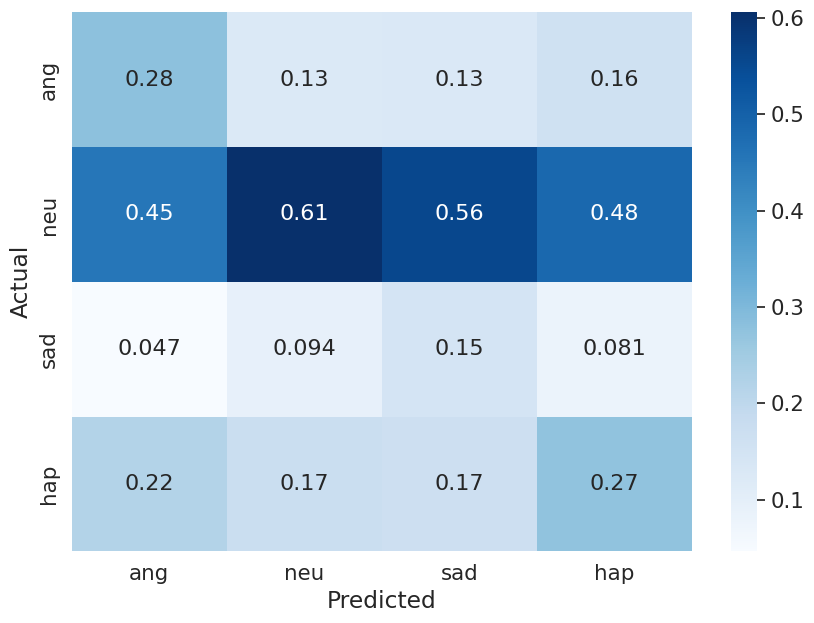

In [19]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

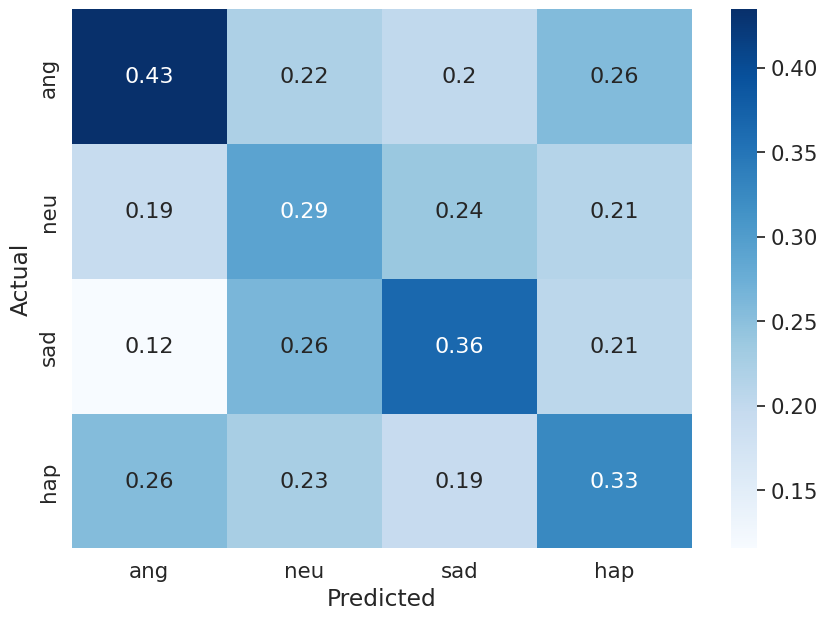

In [20]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [21]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

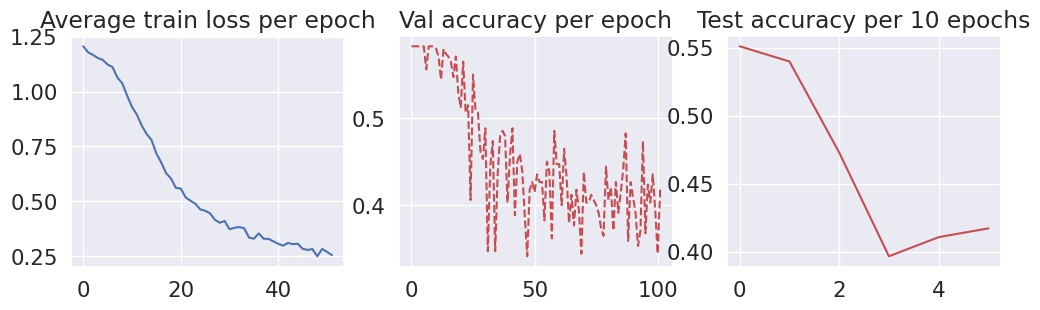

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

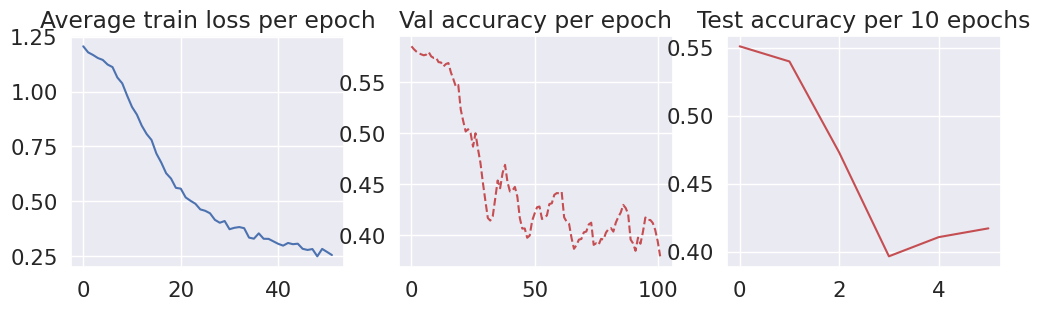

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [24]:
trainer.fit(n_epoch=30, self_supervised=False, train_task='embedding', test_n_epoch=1, lr=5e-5)

  1%|▊                                                                            | 0.33339870562854323/30 [13:26<1044:37:41, 126764.14s/it]

Epoch: 53	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 117/340 (34.41%)



  1%|▉                                                                                | 0.35301039419492763/30 [14:09<19:48:23, 2405.10s/it]

KeyboardInterrupt



In [25]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': log_dir + "model.epoch=41.step=104509.pt"
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")

## run1

In [26]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run1/'
trainer.log_dir = log_dir

In [27]:
iconnet_config = ocf.load(iconnet_config_path)
iconnet_config.fe.n_channel = [456]
iconnet_config.fe.window_k = [5]
iconnet_config.fe.kernel_size = [128]
iconnet_config.cls = {'n_block': 2, 'n_hidden_dim': [512,512], 'norm_type': 'LayerNorm'}
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [128], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [28]:
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [36]:
trainer.setup(model=model, lr=learning_rate)

In [30]:
def get_parameter_names(model, forbidden_layer_types):
    """
    Returns the names of the model parameters that are not inside a forbidden layer.
    """
    result = []
    for name, child in model.named_children():
        result += [
            f"{name}.{n}"
            for n in get_parameter_names(child, forbidden_layer_types)
            if not isinstance(child, tuple(forbidden_layer_types))
        ]
    # Add model specific parameters (defined with nn.Parameter) since they are not in any child.
    result += list(model._parameters.keys())
    return result

In [32]:
decay_parameters = get_parameter_names(model, [nn.LayerNorm])
decay_parameters = [name for name in decay_parameters if "bias" not in name]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if n in decay_parameters],
        "weight_decay": 1e-5,
    },
    {
        "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
        "weight_decay": 0.0,
    },
]

In [33]:
optimizer = torch.optim.SGD(
    optimizer_grouped_parameters, lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, 
    base_lr=1e-4, 
    max_lr=1e-2, 
    step_size_up=5000,
    mode="triangular2")

In [37]:
trainer.fit(
    n_epoch=30, self_supervised=False, 
    train_task='embedding', test_n_epoch=5,
    optimizer=optimizer, scheduler=scheduler
)

  2%|█▏                                                                             | 0.45466702326826747/30 [10:08<562:07:18, 68492.65s/it]

Epoch: 1	Loss: 1.353 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.353]	Val_acc: 198/340 (58.24%)

Saved new best val model: ../scb16_models/meld/run1/model.epoch=1.step=1275.loss=1.353.val_acc=0.582.pt


  3%|██▍                                                                             | 0.9090665953463833/30 [20:32<566:40:00, 70124.96s/it]

Epoch: 1	Loss: 2.051 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.051]	Val_acc: 198/340 (58.24%)



  5%|███▊                                                                                | 1.363733618614506/30 [28:51<8:41:50, 1093.38s/it]

Correct: 937/1700 (0.5512)
Saved new best test model: ../scb16_models/meld/run1/model.epoch=1.step=2549.test_acc=0.5512.pt
{'acc_unweighted': tensor(0.2500),
 'acc_weighted': tensor(0.5512),
 'f1s_unweighted': tensor(0.1777),
 'f1s_weighted': tensor(0.3917),
 'rocauc': tensor(0.5588),
 'uar': tensor(0.2500),
 'wap': tensor(0.3038)}
{'acc_detail': tensor([0., 1., 0., 0.]),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000]),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000]),
 'recall_detail': tensor([0., 1., 0., 0.]),
 'rocauc_detail': tensor([0.5505, 0.5275, 0.5789, 0.5783])}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


  6%|████▊                                                                           | 1.8184006418825909/30 [39:25<543:17:01, 69400.67s/it]

Epoch: 2	Loss: 0.540 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.540]	Val_acc: 198/340 (58.24%)



  8%|██████                                                                          | 2.2728002139605183/30 [49:49<543:58:47, 70628.40s/it]

Epoch: 2	Loss: 1.592 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.592]	Val_acc: 198/340 (58.24%)



  9%|███████                                                                       | 2.7274672372286033/30 [1:00:13<527:14:18, 69595.99s/it]

Epoch: 3	Loss: 0.629 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.629]	Val_acc: 198/340 (58.24%)



 11%|████████▎                                                                     | 3.1818668093065305/30 [1:10:39<516:32:35, 69339.49s/it]

Epoch: 3	Loss: 1.210 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.210]	Val_acc: 198/340 (58.24%)



 12%|█████████▍                                                                    | 3.6365338325746155/30 [1:21:08<517:28:57, 70663.62s/it]

Epoch: 4	Loss: 0.738 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.738]	Val_acc: 198/340 (58.24%)



 14%|██████████▊                                                                    | 4.090933404652693/30 [1:31:35<513:04:41, 71290.93s/it]

Epoch: 4	Loss: 1.236 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.236]	Val_acc: 198/340 (58.24%)



 15%|███████████▉                                                                   | 4.545600427921533/30 [1:42:04<488:17:53, 69059.70s/it]

Epoch: 5	Loss: 1.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.008]	Val_acc: 198/340 (58.24%)



 17%|█████████████▏                                                                 | 5.000000000000215/30 [1:52:24<486:41:13, 70082.93s/it]

Epoch: 5	Loss: 1.488 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.488]	Val_acc: 198/340 (58.24%)



 18%|██████████████▎                                                                | 5.454667023269055/30 [2:02:57<479:01:46, 70258.03s/it]

Epoch: 6	Loss: 0.520 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.520]	Val_acc: 198/340 (58.24%)



 20%|███████████████▌                                                               | 5.909066595347737/30 [2:13:25<466:39:49, 69735.34s/it]

Epoch: 6	Loss: 1.172 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.172]	Val_acc: 198/340 (58.24%)



 21%|█████████████████▏                                                               | 6.3637336186165765/30 [2:21:52<7:24:00, 1127.11s/it]

Correct: 937/1700 (0.5512)
{'acc_unweighted': tensor(0.2500),
 'acc_weighted': tensor(0.5512),
 'f1s_unweighted': tensor(0.1777),
 'f1s_weighted': tensor(0.3917),
 'rocauc': tensor(0.5671),
 'uar': tensor(0.2500),
 'wap': tensor(0.3038)}
{'acc_detail': tensor([0., 1., 0., 0.]),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000]),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000]),
 'recall_detail': tensor([0., 1., 0., 0.]),
 'rocauc_detail': tensor([0.5769, 0.5321, 0.5840, 0.5754])}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


 23%|█████████████████▉                                                             | 6.818400641885416/30 [2:32:29<458:25:19, 71190.94s/it]

Epoch: 7	Loss: 1.331 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.331]	Val_acc: 198/340 (58.24%)



 24%|███████████████████▏                                                           | 7.272800213964098/30 [2:42:54<446:02:24, 70652.97s/it]

Epoch: 7	Loss: 1.091 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.091]	Val_acc: 198/340 (58.24%)



 26%|████████████████████▎                                                          | 7.727467237232938/30 [2:53:29<431:39:20, 69770.25s/it]

Epoch: 8	Loss: 0.563 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.563]	Val_acc: 198/340 (58.24%)



 27%|█████████████████████▊                                                          | 8.18186680931162/30 [3:04:00<429:13:42, 70822.88s/it]

Epoch: 8	Loss: 1.096 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.096]	Val_acc: 198/340 (58.24%)



 29%|███████████████████████                                                         | 8.63653383258046/30 [3:14:40<419:15:42, 70650.65s/it]

Epoch: 9	Loss: 2.046 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.046]	Val_acc: 198/340 (58.24%)



 30%|███████████████████████▉                                                       | 9.090933404659141/30 [3:25:17<412:44:51, 71064.44s/it]

Epoch: 9	Loss: 1.649 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.649]	Val_acc: 198/340 (58.24%)



 32%|█████████████████████████▏                                                     | 9.545600427927981/30 [3:35:56<402:14:16, 70794.37s/it]

Epoch: 10	Loss: 1.953 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.953]	Val_acc: 198/340 (58.24%)



 33%|██████████████████████████                                                    | 10.000000000006663/30 [3:46:37<399:59:51, 71999.57s/it]

Epoch: 10	Loss: 1.289 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.289]	Val_acc: 198/340 (58.24%)



 35%|███████████████████████████▏                                                  | 10.454667023275503/30 [3:57:23<385:58:13, 71090.80s/it]

Epoch: 11	Loss: 1.229 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.229]	Val_acc: 198/340 (58.24%)



 36%|████████████████████████████▎                                                 | 10.909066595354185/30 [4:08:06<379:34:02, 71575.49s/it]

Epoch: 11	Loss: 0.513 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.513]	Val_acc: 198/340 (58.24%)



 38%|██████████████████████████████▋                                                  | 11.363733618623025/30 [4:16:42<5:50:46, 1129.33s/it]

Correct: 937/1700 (0.5512)
{'acc_unweighted': tensor(0.2500),
 'acc_weighted': tensor(0.5512),
 'f1s_unweighted': tensor(0.1777),
 'f1s_weighted': tensor(0.3917),
 'rocauc': tensor(0.5700),
 'uar': tensor(0.2500),
 'wap': tensor(0.3038)}
{'acc_detail': tensor([0., 1., 0., 0.]),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000]),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000]),
 'recall_detail': tensor([0., 1., 0., 0.]),
 'rocauc_detail': tensor([0.5911, 0.5329, 0.5795, 0.5764])}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


 39%|██████████████████████████████▋                                               | 11.818400641891865/30 [4:27:28<359:50:26, 71249.30s/it]

Epoch: 12	Loss: 1.259 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.259]	Val_acc: 198/340 (58.24%)



 41%|███████████████████████████████▉                                              | 12.272800213970546/30 [4:38:10<359:25:56, 72992.73s/it]

Epoch: 12	Loss: 1.184 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.184]	Val_acc: 198/340 (58.24%)



 42%|█████████████████████████████████                                             | 12.727467237239386/30 [4:48:58<344:06:37, 71720.67s/it]

Epoch: 13	Loss: 0.594 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.594]	Val_acc: 198/340 (58.24%)



 44%|██████████████████████████████████▎                                           | 13.181866809318068/30 [4:59:41<337:21:25, 72212.89s/it]

Epoch: 13	Loss: 2.244 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.244]	Val_acc: 198/340 (58.24%)



 45%|███████████████████████████████████▍                                          | 13.636533832586908/30 [5:10:34<332:20:53, 73117.37s/it]

Epoch: 14	Loss: 2.163 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.163]	Val_acc: 198/340 (58.24%)



 47%|█████████████████████████████████████                                          | 14.09093340466559/30 [5:21:18<318:05:45, 71980.70s/it]

Epoch: 14	Loss: 1.103 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.103]	Val_acc: 198/340 (58.24%)



 48%|██████████████████████████████████████▎                                        | 14.54560042793443/30 [5:32:12<313:50:34, 73107.64s/it]

Epoch: 15	Loss: 0.556 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.556]	Val_acc: 198/340 (58.24%)



 50%|███████████████████████████████████████                                       | 15.000000000013111/30 [5:42:59<305:46:28, 73385.93s/it]

Epoch: 15	Loss: 0.602 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.602]	Val_acc: 198/340 (58.24%)



 52%|████████████████████████████████████████▏                                     | 15.454667023281951/30 [5:53:54<289:37:47, 71683.99s/it]

Epoch: 16	Loss: 1.176 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.176]	Val_acc: 198/340 (58.24%)



 53%|█████████████████████████████████████████▎                                    | 15.909066595360633/30 [6:04:38<280:59:20, 71788.07s/it]

Epoch: 16	Loss: 0.536 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.536]	Val_acc: 198/340 (58.24%)



 55%|████████████████████████████████████████████▋                                     | 16.36373361862947/30 [6:13:23<4:20:18, 1145.34s/it]

Correct: 937/1700 (0.5512)
{'acc_unweighted': tensor(0.2500),
 'acc_weighted': tensor(0.5512),
 'f1s_unweighted': tensor(0.1777),
 'f1s_weighted': tensor(0.3917),
 'rocauc': tensor(0.5705),
 'uar': tensor(0.2500),
 'wap': tensor(0.3038)}
{'acc_detail': tensor([0., 1., 0., 0.]),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000]),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000]),
 'recall_detail': tensor([0., 1., 0., 0.]),
 'rocauc_detail': tensor([0.5923, 0.5337, 0.5805, 0.5757])}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


 56%|████████████████████████████████████████████▎                                  | 16.81840064189831/30 [6:24:21<263:18:09, 71910.03s/it]

Epoch: 17	Loss: 1.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.001]	Val_acc: 198/340 (58.24%)



 58%|████████████████████████████████████████████▉                                 | 17.272800213976993/30 [6:35:09<259:03:59, 73279.26s/it]

Epoch: 17	Loss: 0.575 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.575]	Val_acc: 198/340 (58.24%)



 59%|██████████████████████████████████████████████                                | 17.727467237245833/30 [6:46:08<246:36:53, 72341.53s/it]

Epoch: 18	Loss: 0.570 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.570]	Val_acc: 198/340 (58.24%)



 61%|███████████████████████████████████████████████▎                              | 18.181866809324514/30 [6:57:02<241:00:18, 73414.19s/it]

Epoch: 18	Loss: 1.286 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.286]	Val_acc: 198/340 (58.24%)



 62%|████████████████████████████████████████████████▍                             | 18.636533832593354/30 [7:08:04<228:40:02, 72442.91s/it]

Epoch: 19	Loss: 0.580 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.580]	Val_acc: 198/340 (58.24%)



 64%|█████████████████████████████████████████████████▋                            | 19.090933404672036/30 [7:19:00<224:35:51, 74117.37s/it]

Epoch: 19	Loss: 1.122 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.122]	Val_acc: 198/340 (58.24%)



 65%|██████████████████████████████████████████████████▊                           | 19.545600427940876/30 [7:30:03<211:32:56, 72847.47s/it]

Epoch: 20	Loss: 1.094 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.094]	Val_acc: 198/340 (58.24%)



 67%|████████████████████████████████████████████████████                          | 20.000000000019558/30 [7:41:01<204:10:53, 73505.35s/it]

Epoch: 20	Loss: 1.086 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.086]	Val_acc: 198/340 (58.24%)



 68%|█████████████████████████████████████████████████████▏                        | 20.454667023288398/30 [7:52:11<197:41:47, 74560.76s/it]

Epoch: 21	Loss: 0.774 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.774]	Val_acc: 198/340 (58.24%)



 70%|███████████████████████████████████████████████████████                        | 20.90906659536708/30 [8:03:20<186:36:04, 73893.91s/it]

Epoch: 21	Loss: 1.102 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.102]	Val_acc: 198/340 (58.24%)



 71%|██████████████████████████████████████████████████████████▍                       | 21.36373361863592/30 [8:12:19<2:53:13, 1203.52s/it]

Correct: 937/1700 (0.5512)
{'acc_unweighted': tensor(0.2500),
 'acc_weighted': tensor(0.5512),
 'f1s_unweighted': tensor(0.1777),
 'f1s_weighted': tensor(0.3917),
 'rocauc': tensor(0.5674),
 'uar': tensor(0.2500),
 'wap': tensor(0.3038)}
{'acc_detail': tensor([0., 1., 0., 0.]),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000]),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000]),
 'recall_detail': tensor([0., 1., 0., 0.]),
 'rocauc_detail': tensor([0.5838, 0.5348, 0.5755, 0.5755])}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


 73%|█████████████████████████████████████████████████████████▍                     | 21.81840064190476/30 [8:23:41<168:14:15, 74026.55s/it]

Epoch: 22	Loss: 1.220 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.220]	Val_acc: 198/340 (58.24%)



 74%|██████████████████████████████████████████████████████████▋                    | 22.27280021398344/30 [8:34:52<158:00:47, 73616.28s/it]

Epoch: 22	Loss: 0.607 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.607]	Val_acc: 198/340 (58.24%)



 76%|███████████████████████████████████████████████████████████▊                   | 22.72746723725228/30 [8:46:19<151:57:20, 75220.05s/it]

Epoch: 23	Loss: 1.576 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.576]	Val_acc: 198/340 (58.24%)



 77%|████████████████████████████████████████████████████████████▎                 | 23.181866809330963/30 [8:57:39<141:28:10, 74696.40s/it]

Epoch: 23	Loss: 1.034 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.034]	Val_acc: 198/340 (58.24%)



 79%|███████████████████████████████████████████████████████████████▋                 | 23.610591067154463/30 [9:07:26<2:22:38, 1339.55s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x776db50f1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x776db50f1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 79%|████████████████████████████████████████████████████████████████▌                 | 23.61085851834462/30 [9:07:26<2:28:08, 1391.17s/i

In [38]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run2/'
trainer.log_dir = log_dir

In [39]:
iconnet_config = ocf.load(iconnet_config_path)
iconnet_config.fe.n_channel = [456]
iconnet_config.fe.window_k = [2]
iconnet_config.fe.kernel_size = [511]
iconnet_config.cls = {'n_block': 1, 'n_hidden_dim': [512], 'norm_type': 'LayerNorm'}
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [2], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 1, 'n_hidden_dim': [512], 'norm_type': 'LayerNorm'}}


In [40]:
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [45]:
trainer.setup(model=model, lr=learning_rate)

In [47]:
trainer.fit(
    n_epoch=50, self_supervised=False, 
    train_task='embedding', test_n_epoch=10)

  1%|▋                                                                             | 0.47632390025215354/50 [14:19<1241:40:47, 90260.83s/it]

Epoch: 2	Loss: 1.159 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.159]	Val_acc: 198/340 (58.24%)

Saved new best val model: ../scb16_models/meld/run2/model.epoch=2.step=1292.loss=1.159.val_acc=0.582.pt


  2%|█▌                                                                             | 0.9523676099747226/50 [28:37<1248:49:36, 91661.45s/it]

Epoch: 2	Loss: 1.107 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.107]	Val_acc: 197/340 (57.94%)



  3%|██▎                                                                               | 1.4286915102270215/50 [37:10<14:27:28, 1071.59s/it]

Correct: 937/1700 (0.5512)
Saved new best test model: ../scb16_models/meld/run2/model.epoch=2.step=2566.test_acc=0.5512.pt
{'acc_unweighted': tensor(0.2514),
 'acc_weighted': tensor(0.5512),
 'f1s_unweighted': tensor(0.1814),
 'f1s_weighted': tensor(0.3938),
 'rocauc': tensor(0.5581),
 'uar': tensor(0.2514),
 'wap': tensor(0.3795)}
{'acc_detail': tensor([0.0078, 0.9979, 0.0000, 0.0000]),
 'f1s_detail': tensor([0.0153, 0.7102, 0.0000, 0.0000]),
 'precision_detail': tensor([0.5000, 0.5513, 0.0000, 0.0000]),
 'recall_detail': tensor([0.0078, 0.9979, 0.0000, 0.0000]),
 'rocauc_detail': tensor([0.6742, 0.5695, 0.4512, 0.5374])}
tensor([[  2, 255,   0,   0],
        [  2, 935,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


  4%|███                                                                            | 1.9050154104793393/50 [51:38<1221:15:33, 91413.55s/it]

Epoch: 3	Loss: 0.576 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.576]	Val_acc: 196/340 (57.65%)



  5%|███▋                                                                         | 2.3810591202020968/50 [1:05:59<1207:10:04, 91262.10s/it]

Epoch: 3	Loss: 0.215 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.215]	Val_acc: 194/340 (57.06%)



  6%|████▍                                                                        | 2.8573830204544146/50 [1:20:25<1205:04:09, 92023.95s/it]

Epoch: 4	Loss: 1.427 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.427]	Val_acc: 197/340 (57.94%)



  7%|█████▏                                                                       | 3.3334267301771723/50 [1:34:56<1193:17:01, 92053.49s/it]

Epoch: 4	Loss: 0.763 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.763]	Val_acc: 199/340 (58.53%)

Saved new best val model: ../scb16_models/meld/run2/model.epoch=4.step=7664.loss=0.763.val_acc=0.585.pt


  8%|██████                                                                         | 3.80975063042949/50 [1:49:31<1177:42:41, 91789.11s/it]

Epoch: 5	Loss: 1.204 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.204]	Val_acc: 196/340 (57.65%)



  9%|██████▋                                                                       | 4.285794340152248/50 [2:03:56<1176:34:58, 92656.07s/it]

Epoch: 5	Loss: 0.985 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.985]	Val_acc: 179/340 (52.65%)



 10%|███████▍                                                                      | 4.762118240404566/50 [2:18:26<1152:27:40, 91712.10s/it]

Epoch: 6	Loss: 1.592 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.592]	Val_acc: 195/340 (57.35%)



 10%|████████▏                                                                     | 5.238161950127323/50 [2:32:58<1146:32:55, 92211.94s/it]

Epoch: 6	Loss: 0.566 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.566]	Val_acc: 183/340 (53.82%)



 11%|████████▉                                                                     | 5.714485850379641/50 [2:47:29<1134:06:17, 92192.16s/it]

Epoch: 7	Loss: 1.492 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.492]	Val_acc: 194/340 (57.06%)



 12%|█████████▋                                                                    | 6.190529560102399/50 [3:02:00<1140:28:14, 93717.06s/it]

Epoch: 7	Loss: 0.363 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.363]	Val_acc: 197/340 (57.94%)



 13%|██████████▍                                                                   | 6.666853460354717/50 [3:16:33<1119:35:58, 93013.29s/it]

Epoch: 8	Loss: 2.206 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.206]	Val_acc: 199/340 (58.53%)



 14%|███████████▏                                                                  | 7.142897170077474/50 [3:31:09<1100:45:46, 92464.16s/it]

Epoch: 8	Loss: 0.888 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.888]	Val_acc: 181/340 (53.24%)



 15%|███████████▉                                                                  | 7.619221070329792/50 [3:45:43<1092:32:59, 92805.75s/it]

Epoch: 9	Loss: 0.100 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.100]	Val_acc: 199/340 (58.53%)



 16%|████████████▋                                                                 | 8.095264780052549/50 [4:00:25<1090:27:52, 93680.89s/it]

Epoch: 9	Loss: 0.411 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.411]	Val_acc: 193/340 (56.76%)



 17%|█████████████▎                                                                | 8.571588680304867/50 [4:15:01<1070:24:01, 93014.47s/it]

Epoch: 10	Loss: 0.902 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.902]	Val_acc: 188/340 (55.29%)



 18%|██████████████                                                                | 9.047632390027625/50 [4:29:40<1071:05:29, 94156.45s/it]

Epoch: 10	Loss: 1.060 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.060]	Val_acc: 188/340 (55.29%)



 19%|██████████████▊                                                               | 9.523956290279942/50 [4:44:21<1049:04:24, 93306.17s/it]

Epoch: 11	Loss: 0.184 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.184]	Val_acc: 183/340 (53.82%)



 20%|███████████████▊                                                               | 10.0000000000027/50 [4:59:01<1039:50:17, 93585.44s/it]

Epoch: 11	Loss: 0.741 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.741]	Val_acc: 148/340 (43.53%)



 21%|████████████████▏                                                            | 10.476323900255018/50 [5:13:41<1024:14:08, 93292.13s/it]

Epoch: 12	Loss: 0.466 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.466]	Val_acc: 188/340 (55.29%)



 22%|████████████████▊                                                            | 10.952367609977776/50 [5:28:19<1013:43:46, 93460.88s/it]

Epoch: 12	Loss: 1.053 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.053]	Val_acc: 163/340 (47.94%)



 23%|██████████████████▎                                                             | 11.428691510230093/50 [5:37:18<12:20:37, 1152.10s/it]

Correct: 741/1700 (0.4359)
{'acc_unweighted': tensor(0.3201),
 'acc_weighted': tensor(0.4359),
 'f1s_unweighted': tensor(0.2908),
 'f1s_weighted': tensor(0.4188),
 'rocauc': tensor(0.5940),
 'uar': tensor(0.3201),
 'wap': tensor(0.4221)}
{'acc_detail': tensor([0.5097, 0.5870, 0.0186, 0.1652]),
 'f1s_detail': tensor([0.3443, 0.5854, 0.0302, 0.2032]),
 'precision_detail': tensor([0.2599, 0.5839, 0.0789, 0.2639]),
 'recall_detail': tensor([0.5097, 0.5870, 0.0186, 0.1652]),
 'rocauc_detail': tensor([0.6681, 0.5567, 0.6016, 0.5495])}
tensor([[131,  89,   8,  29],
        [254, 550,  19, 114],
        [ 32, 110,   3,  16],
        [ 87, 193,   8,  57]])


 24%|██████████████████▌                                                           | 11.905015410482411/50 [5:52:04<986:04:43, 93185.05s/it]

Epoch: 13	Loss: 0.618 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.618]	Val_acc: 158/340 (46.47%)



 25%|███████████████████▎                                                          | 12.381059120205169/50 [6:06:37<991:20:14, 94867.50s/it]

Epoch: 13	Loss: 0.251 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.251]	Val_acc: 186/340 (54.71%)



 26%|████████████████████                                                          | 12.857383020457487/50 [6:21:24<982:15:15, 95203.72s/it]

Epoch: 14	Loss: 0.182 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.182]	Val_acc: 185/340 (54.41%)



 27%|████████████████████▊                                                         | 13.333426730180244/50 [6:36:02<959:13:39, 94178.96s/it]

Epoch: 14	Loss: 0.287 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.287]	Val_acc: 156/340 (45.88%)



 28%|█████████████████████▌                                                        | 13.809750630432562/50 [6:50:52<944:21:03, 93938.66s/it]

Epoch: 15	Loss: 0.028 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.028]	Val_acc: 179/340 (52.65%)



 29%|██████████████████████▌                                                        | 14.28579434015532/50 [7:05:38<930:17:30, 93773.64s/it]

Epoch: 15	Loss: 0.731 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.731]	Val_acc: 136/340 (40.00%)



 30%|███████████████████████                                                       | 14.762118240407638/50 [7:20:24<923:05:11, 94305.10s/it]

Epoch: 16	Loss: 0.125 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.125]	Val_acc: 177/340 (52.06%)



 30%|███████████████████████▊                                                      | 15.238161950130396/50 [7:35:20<925:15:12, 95820.96s/it]

Epoch: 16	Loss: 0.457 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.457]	Val_acc: 128/340 (37.65%)



 31%|████████████████████████▌                                                     | 15.714485850382713/50 [7:50:16<907:09:08, 95251.55s/it]

Epoch: 17	Loss: 0.221 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.221]	Val_acc: 154/340 (45.29%)



 32%|█████████████████████████▎                                                    | 16.190529560104263/50 [8:05:03<894:43:29, 95269.46s/it]

Epoch: 17	Loss: 1.228 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.228]	Val_acc: 168/340 (49.41%)



 33%|██████████████████████████▎                                                    | 16.66685346035356/50 [8:19:58<883:59:51, 95472.27s/it]

Epoch: 18	Loss: 0.713 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.713]	Val_acc: 180/340 (52.94%)



 34%|███████████████████████████▍                                                    | 17.1428971700733/50 [8:34:53<875:00:25, 95870.44s/it]

Epoch: 18	Loss: 0.911 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.911]	Val_acc: 134/340 (39.41%)



 35%|████████████████████████████▏                                                   | 17.6192210703226/50 [8:49:46<856:26:41, 95217.03s/it]

Epoch: 19	Loss: 0.296 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.296]	Val_acc: 148/340 (43.53%)



 36%|████████████████████████████▌                                                  | 18.09526478004234/50 [9:05:29<884:56:55, 99854.01s/it]

Epoch: 19	Loss: 0.763 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.763]	Val_acc: 162/340 (47.65%)



 37%|████████████████████████████▉                                                 | 18.571588680291637/50 [9:21:18<864:10:12, 98987.25s/it]

Epoch: 20	Loss: 1.010 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.010]	Val_acc: 170/340 (50.00%)



 38%|█████████████████████████████▋                                                | 19.047632390011376/50 [9:37:08<855:13:09, 99468.62s/it]

Epoch: 20	Loss: 0.051 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.051]	Val_acc: 140/340 (41.18%)



 39%|██████████████████████████████                                               | 19.523956290260674/50 [9:53:02<847:47:14, 100145.36s/it]

Epoch: 21	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 133/340 (39.12%)



 40%|██████████████████████████████▊                                              | 19.999999999980414/50 [10:08:52<826:46:25, 99212.86s/it]

Epoch: 21	Loss: 0.382 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.382]	Val_acc: 176/340 (51.76%)



 41%|███████████████████████████████▌                                             | 20.476323900229712/50 [10:24:44<818:21:56, 99788.26s/it]

Epoch: 22	Loss: 0.303 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.303]	Val_acc: 171/340 (50.29%)



 42%|████████████████████████████████▎                                            | 20.95236760994945/50 [10:40:41<807:57:14, 100133.27s/it]

Epoch: 22	Loss: 3.041 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=3.041]	Val_acc: 176/340 (51.76%)



 43%|██████████████████████████████████▋                                              | 21.42869151019875/50 [10:50:02<9:18:08, 1172.10s/it]

Correct: 805/1700 (0.4735)
{'acc_unweighted': tensor(0.2581),
 'acc_weighted': tensor(0.4735),
 'f1s_unweighted': tensor(0.2456),
 'f1s_weighted': tensor(0.4150),
 'rocauc': tensor(0.5511),
 'uar': tensor(0.2581),
 'wap': tensor(0.4018)}
{'acc_detail': tensor([0.0817, 0.7780, 0.0248, 0.1478]),
 'f1s_detail': tensor([0.1308, 0.6500, 0.0369, 0.1648]),
 'precision_detail': tensor([0.3281, 0.5582, 0.0714, 0.1861]),
 'recall_detail': tensor([0.0817, 0.7780, 0.0248, 0.1478]),
 'rocauc_detail': tensor([0.6192, 0.5285, 0.5657, 0.4910])}
tensor([[ 21, 175,   6,  55],
        [ 33, 729,  33, 142],
        [  3, 128,   4,  26],
        [  7, 274,  13,  51]])


 44%|█████████████████████████████████▋                                           | 21.905015410448048/50 [11:05:08<754:10:25, 96637.38s/it]

Epoch: 23	Loss: 1.364 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.364]	Val_acc: 133/340 (39.12%)



 45%|██████████████████████████████████▍                                          | 22.381059120167787/50 [11:20:15<745:08:32, 97125.83s/it]

Epoch: 23	Loss: 0.613 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.613]	Val_acc: 175/340 (51.47%)



 46%|██████████████████████████████████▋                                         | 22.857383020417085/50 [11:35:38<755:04:43, 100148.16s/it]

Epoch: 24	Loss: 0.129 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.129]	Val_acc: 163/340 (47.94%)



 47%|███████████████████████████████████▉                                         | 23.333426730136825/50 [11:51:35<739:12:18, 99793.06s/it]

Epoch: 24	Loss: 2.321 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.321]	Val_acc: 158/340 (46.47%)



 48%|████████████████████████████████████▏                                       | 23.809750630386123/50 [12:07:35<735:58:57, 101165.04s/it]

Epoch: 25	Loss: 1.723 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.723]	Val_acc: 155/340 (45.59%)



 49%|█████████████████████████████████████▍                                       | 24.285794340105863/50 [12:23:07<689:12:03, 96488.43s/it]

Epoch: 25	Loss: 0.276 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.276]	Val_acc: 170/340 (50.00%)



 50%|██████████████████████████████████████▋                                       | 24.76211824035516/50 [12:38:21<679:16:47, 96894.33s/it]

Epoch: 26	Loss: 0.068 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.068]	Val_acc: 177/340 (52.06%)



 50%|███████████████████████████████████████▉                                       | 25.2381619500749/50 [12:53:26<665:49:27, 96800.87s/it]

Epoch: 26	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 175/340 (51.47%)



 51%|████████████████████████████████████████▋                                      | 25.7144858503242/50 [13:08:36<658:07:17, 97557.64s/it]

Epoch: 27	Loss: 0.677 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.677]	Val_acc: 133/340 (39.12%)



 52%|████████████████████████████████████████▎                                    | 26.190529560043938/50 [13:23:54<650:27:12, 98348.79s/it]

Epoch: 27	Loss: 1.177 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.177]	Val_acc: 185/340 (54.41%)



 53%|████████████████████████████████████████▌                                   | 26.666853460293236/50 [13:39:38<653:45:40, 100866.83s/it]

Epoch: 28	Loss: 0.020 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.020]	Val_acc: 133/340 (39.12%)



 54%|█████████████████████████████████████████▎                                  | 27.142897170012976/50 [13:55:41<639:19:50, 100694.78s/it]

Epoch: 28	Loss: 0.031 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.031]	Val_acc: 152/340 (44.71%)



 55%|█████████████████████████████████████████▉                                  | 27.619221070262274/50 [14:11:52<633:25:47, 101888.66s/it]

Epoch: 29	Loss: 0.387 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.387]	Val_acc: 160/340 (47.06%)



 56%|██████████████████████████████████████████▋                                 | 28.095264779982013/50 [14:27:55<614:44:04, 101030.40s/it]

Epoch: 29	Loss: 0.026 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.026]	Val_acc: 119/340 (35.00%)



 57%|████████████████████████████████████████████                                 | 28.57158868023131/50 [14:44:03<601:57:53, 101130.85s/it]

Epoch: 30	Loss: 0.177 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.177]	Val_acc: 151/340 (44.41%)



 58%|█████████████████████████████████████████████▎                                | 29.04763238995105/50 [14:59:36<570:06:52, 97956.12s/it]

Epoch: 30	Loss: 0.425 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.425]	Val_acc: 147/340 (43.24%)



 59%|██████████████████████████████████████████████                                | 29.52395629020035/50 [15:14:56<566:50:42, 99660.00s/it]

Epoch: 31	Loss: 0.041 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.041]	Val_acc: 153/340 (45.00%)



 60%|██████████████████████████████████████████████▊                               | 29.99999999992009/50 [15:30:20<548:50:31, 98791.58s/it]

Epoch: 31	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 105/340 (30.88%)



 61%|██████████████████████████████████████████████▉                              | 30.476323900169387/50 [15:45:41<532:06:11, 98115.32s/it]

Epoch: 32	Loss: 0.065 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.065]	Val_acc: 122/340 (35.88%)



 62%|███████████████████████████████████████████████▋                             | 30.952367609889126/50 [16:01:04<519:49:42, 98247.50s/it]

Epoch: 32	Loss: 0.011 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.011]	Val_acc: 108/340 (31.76%)



 63%|██████████████████████████████████████████████████▎                             | 31.428691510138425/50 [16:10:46<6:19:45, 1226.91s/it]

Correct: 547/1700 (0.3218)
{'acc_unweighted': tensor(0.2989),
 'acc_weighted': tensor(0.3218),
 'f1s_unweighted': tensor(0.2645),
 'f1s_weighted': tensor(0.3342),
 'rocauc': tensor(0.5715),
 'uar': tensor(0.2989),
 'wap': tensor(0.4124)}
{'acc_detail': tensor([0.4591, 0.3148, 0.0621, 0.3594]),
 'f1s_detail': tensor([0.2995, 0.4106, 0.0741, 0.2740]),
 'precision_detail': tensor([0.2222, 0.5900, 0.0917, 0.2214]),
 'recall_detail': tensor([0.4591, 0.3148, 0.0621, 0.3594]),
 'rocauc_detail': tensor([0.6338, 0.5355, 0.5865, 0.5301])}
tensor([[118,  51,  16,  72],
        [287, 295,  59, 296],
        [ 37,  46,  10,  68],
        [ 89, 108,  24, 124]])


 64%|█████████████████████████████████████████████████▏                           | 31.905015410387723/50 [16:26:15<494:45:57, 98433.79s/it]

Epoch: 33	Loss: 0.134 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.134]	Val_acc: 118/340 (34.71%)



 65%|█████████████████████████████████████████████████▊                           | 32.381059120107466/50 [16:41:34<484:03:39, 98906.05s/it]

Epoch: 33	Loss: 0.881 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.881]	Val_acc: 127/340 (37.35%)



 66%|██████████████████████████████████████████████████▌                          | 32.857383020356764/50 [16:57:02<471:47:23, 99077.29s/it]

Epoch: 34	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 164/340 (48.24%)



 67%|████████████████████████████████████████████████████▋                          | 33.3334267300765/50 [17:12:25<457:02:25, 98721.30s/it]

Epoch: 34	Loss: 0.164 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.164]	Val_acc: 154/340 (45.29%)



 68%|█████████████████████████████████████████████████████▍                         | 33.8097506303258/50 [17:27:51<446:23:16, 99257.07s/it]

Epoch: 35	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 122/340 (35.88%)



 69%|█████████████████████████████████████████████████████▍                        | 34.28579434004554/50 [17:43:20<432:00:57, 98971.45s/it]

Epoch: 35	Loss: 0.199 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.199]	Val_acc: 122/340 (35.88%)



 70%|██████████████████████████████████████████████████████▏                       | 34.76211824029484/50 [17:58:52<418:26:52, 98859.67s/it]

Epoch: 36	Loss: 0.009 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.009]	Val_acc: 157/340 (46.18%)



 70%|██████████████████████████████████████████████████████▉                       | 35.23816195001458/50 [18:14:22<407:28:27, 99371.61s/it]

Epoch: 36	Loss: 0.520 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.520]	Val_acc: 136/340 (40.00%)



 71%|███████████████████████████████████████████████████████▋                      | 35.71448585026388/50 [18:29:59<394:08:54, 99326.79s/it]

Epoch: 37	Loss: 0.205 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.205]	Val_acc: 168/340 (49.41%)



 72%|████████████████████████████████████████████████████████▍                     | 36.19052955998362/50 [18:45:30<381:06:22, 99350.82s/it]

Epoch: 37	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 152/340 (44.71%)



 73%|███████████████████████████████████████████████████████▋                    | 36.666853460232915/50 [19:01:02<370:24:43, 100012.70s/it]

Epoch: 38	Loss: 0.012 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.012]	Val_acc: 164/340 (48.24%)



 74%|█████████████████████████████████████████████████████████▏                   | 37.142897169952654/50 [19:16:37<355:32:31, 99552.11s/it]

Epoch: 38	Loss: 0.137 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.137]	Val_acc: 152/340 (44.71%)



 75%|██████████████████████████████████████████████████████████▋                   | 37.61922107020195/50 [19:32:12<343:19:28, 99829.63s/it]

Epoch: 39	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 183/340 (53.82%)



 76%|██████████████████████████████████████████████████████████▋                  | 38.09526477992169/50 [19:47:48<334:28:26, 101145.18s/it]

Epoch: 39	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 169/340 (49.71%)



 77%|███████████████████████████████████████████████████████████▍                 | 38.57158868017099/50 [20:03:27<320:46:15, 101044.27s/it]

Epoch: 40	Loss: 0.213 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.213]	Val_acc: 156/340 (45.88%)



 78%|████████████████████████████████████████████████████████████▏                | 39.04763238989073/50 [20:19:04<305:25:48, 100393.64s/it]

Epoch: 40	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 131/340 (38.53%)



 79%|████████████████████████████████████████████████████████████▊                | 39.52395629014003/50 [20:34:39<292:53:34, 100650.10s/it]

Epoch: 41	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 158/340 (46.47%)



 80%|█████████████████████████████████████████████████████████████▌               | 39.99999999985977/50 [20:50:25<282:39:53, 101759.32s/it]

Epoch: 41	Loss: 0.015 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.015]	Val_acc: 149/340 (43.82%)



 81%|█████████████████████████████████████████████████████████████▌              | 40.476323900109065/50 [21:06:08<266:04:32, 100578.06s/it]

Epoch: 42	Loss: 1.583 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.583]	Val_acc: 151/340 (44.41%)



 82%|██████████████████████████████████████████████████████████████▏             | 40.952367609828805/50 [21:21:51<252:23:02, 100422.07s/it]

Epoch: 42	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 126/340 (37.06%)



 83%|███████████████████████████████████████████████████████████████████▉              | 41.4286915100781/50 [21:31:55<2:59:49, 1258.82s/it]

Correct: 586/1700 (0.3447)
{'acc_unweighted': tensor(0.3030),
 'acc_weighted': tensor(0.3447),
 'f1s_unweighted': tensor(0.2870),
 'f1s_weighted': tensor(0.3678),
 'rocauc': tensor(0.5637),
 'uar': tensor(0.3030),
 'wap': tensor(0.4203)}
{'acc_detail': tensor([0.3696, 0.3906, 0.1677, 0.2841]),
 'f1s_detail': tensor([0.3025, 0.4710, 0.1247, 0.2497]),
 'precision_detail': tensor([0.2561, 0.5932, 0.0993, 0.2227]),
 'recall_detail': tensor([0.3696, 0.3906, 0.1677, 0.2841]),
 'rocauc_detail': tensor([0.6381, 0.5489, 0.5501, 0.5176])}
tensor([[ 95,  70,  36,  56],
        [190, 366, 148, 233],
        [ 23,  58,  27,  53],
        [ 63, 123,  61,  98]])


 84%|██████████████████████████████████████████████████████████████████▏            | 41.9050154103274/50 [21:47:40<224:25:11, 99803.96s/it]

Epoch: 43	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 160/340 (47.06%)



 85%|█████████████████████████████████████████████████████████████████▎           | 42.38105912004714/50 [22:03:13<215:47:17, 101961.41s/it]

Epoch: 43	Loss: 0.023 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.023]	Val_acc: 153/340 (45.00%)



 86%|██████████████████████████████████████████████████████████████████           | 42.85738302029644/50 [22:18:59<199:30:04, 100552.00s/it]

Epoch: 44	Loss: 0.141 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.141]	Val_acc: 170/340 (50.00%)



 87%|██████████████████████████████████████████████████████████████████▋          | 43.33342673001618/50 [22:34:38<189:36:36, 102390.89s/it]

Epoch: 44	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 155/340 (45.59%)



 88%|██████████████████████████████████████████████████████████████████▌         | 43.809750630265476/50 [22:50:24<174:51:01, 101685.90s/it]

Epoch: 45	Loss: 0.013 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.013]	Val_acc: 129/340 (37.94%)



 89%|███████████████████████████████████████████████████████████████████▎        | 44.285794339985216/50 [23:06:12<163:05:12, 102746.19s/it]

Epoch: 45	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 132/340 (38.82%)



 90%|████████████████████████████████████████████████████████████████████        | 44.762118240234514/50 [23:22:03<149:09:49, 102520.44s/it]

Epoch: 46	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 167/340 (49.12%)



 90%|████████████████████████████████████████████████████████████████████▊       | 45.238161949954254/50 [23:37:48<134:32:47, 101718.52s/it]

Epoch: 46	Loss: 0.179 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.179]	Val_acc: 172/340 (50.59%)



 91%|██████████████████████████████████████████████████████████████████████▍      | 45.71448585020355/50 [23:53:36<120:18:59, 101070.65s/it]

Epoch: 47	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 113/340 (33.24%)



 92%|███████████████████████████████████████████████████████████████████████▏     | 46.19052955992329/50 [24:09:26<108:21:06, 102393.89s/it]

Epoch: 47	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 152/340 (44.71%)



 93%|████████████████████████████████████████████████████████████████████████▊     | 46.66685346017259/50 [24:25:19<94:10:26, 101713.65s/it]

Epoch: 48	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 148/340 (43.53%)



 94%|█████████████████████████████████████████████████████████████████████████▌    | 47.14289716989233/50 [24:41:12<80:54:00, 101935.63s/it]

Epoch: 48	Loss: 0.020 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.020]	Val_acc: 137/340 (40.29%)



 95%|██████████████████████████████████████████████████████████████████████████▎   | 47.61922107014163/50 [24:57:08<67:19:22, 101799.70s/it]

Epoch: 49	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 151/340 (44.41%)



 96%|███████████████████████████████████████████████████████████████████████████   | 48.09526477986137/50 [25:12:57<53:55:56, 101933.57s/it]

Epoch: 49	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 163/340 (47.94%)



 97%|██████████████████████████████████████████████████████████████████████████▊  | 48.571588680110665/50 [25:28:49<40:29:18, 102042.64s/it]

Epoch: 50	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 134/340 (39.41%)



 98%|███████████████████████████████████████████████████████████████████████████▌ | 49.047632389830405/50 [25:44:47<27:18:13, 103209.34s/it]

Epoch: 50	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 158/340 (46.47%)



 99%|██████████████████████████████████████████████████████████████████████████████▏| 49.5239562900797/50 [26:00:44<13:31:05, 102228.33s/it]

Epoch: 51	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 158/340 (46.47%)



100%|████████████████████████████████████████████████████████████████████████████████▉| 49.99999999979944/50 [26:16:41<00:00, 103266.36s/it]

Epoch: 51	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 130/340 (38.24%)



100%|██████████████████████████████████████████████████████████████████████████████████▉| 49.99999999979944/50 [26:16:41<00:00, 1892.04s/it]


In [48]:
trainer.fit(
    n_epoch=40, self_supervised=False, 
    train_task='embedding', test_n_epoch=1)

  1%|▋                                                                            | 0.33339870562854323/40 [15:54<1617:04:10, 146759.51s/it]

Epoch: 52	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 127/340 (37.35%)



  2%|█▎                                                                            | 0.6666012943714613/40 [31:47<1604:25:50, 146845.96s/it]

Epoch: 52	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 138/340 (40.59%)



  3%|██                                                                                | 1.0000000000000904/40 [42:10<20:31:48, 1895.10s/it]

Correct: 641/1700 (0.3771)
{'acc_unweighted': tensor(0.2793),
 'acc_weighted': tensor(0.3771),
 'f1s_unweighted': tensor(0.2777),
 'f1s_weighted': tensor(0.3877),
 'rocauc': tensor(0.5547),
 'uar': tensor(0.2793),
 'wap': tensor(0.4142)}
{'acc_detail': tensor([0.1829, 0.4899, 0.0994, 0.3449]),
 'f1s_detail': tensor([0.2222, 0.5319, 0.1063, 0.2505]),
 'precision_detail': tensor([0.2831, 0.5817, 0.1143, 0.1967]),
 'recall_detail': tensor([0.1829, 0.4899, 0.0994, 0.3449]),
 'rocauc_detail': tensor([0.6281, 0.5378, 0.5509, 0.5022])}
tensor([[ 47,  86,  19, 105],
        [ 85, 459,  70, 323],
        [ 13,  74,  16,  58],
        [ 21, 170,  35, 119]])


  3%|██▌                                                                           | 1.3333987056287195/40 [58:46<1626:09:55, 151401.88s/it]

Epoch: 53	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 171/340 (50.29%)



  4%|███▏                                                                        | 1.6666012943716848/40 [1:15:28<1632:49:50, 153343.83s/it]

Epoch: 53	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 171/340 (50.29%)



  5%|████                                                                             | 2.000000000000314/40 [1:25:54<19:41:08, 1864.95s/it]

Correct: 771/1700 (0.4535)
{'acc_unweighted': tensor(0.2878),
 'acc_weighted': tensor(0.4535),
 'f1s_unweighted': tensor(0.2882),
 'f1s_weighted': tensor(0.4287),
 'rocauc': tensor(0.5542),
 'uar': tensor(0.2878),
 'wap': tensor(0.4155)}
{'acc_detail': tensor([0.2179, 0.6948, 0.0994, 0.1391]),
 'f1s_detail': tensor([0.2563, 0.6287, 0.1009, 0.1670]),
 'precision_detail': tensor([0.3111, 0.5741, 0.1026, 0.2087]),
 'recall_detail': tensor([0.2179, 0.6948, 0.0994, 0.1391]),
 'rocauc_detail': tensor([0.6232, 0.5360, 0.5382, 0.5194])}
tensor([[ 56, 146,  16,  39],
        [ 84, 651,  81, 121],
        [ 12, 111,  16,  22],
        [ 28, 226,  43,  48]])


  6%|████▍                                                                       | 2.3333987056285657/40 [1:42:44<1595:29:01, 152488.98s/it]

Epoch: 54	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 140/340 (41.18%)



  7%|█████                                                                       | 2.6666012943711537/40 [1:59:38<1595:43:14, 153872.80s/it]

Epoch: 54	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 154/340 (45.29%)



  7%|█████▉                                                                          | 2.9999999999994054/40 [2:10:07<19:28:46, 1895.31s/it]

Correct: 685/1700 (0.4029)
{'acc_unweighted': tensor(0.2844),
 'acc_weighted': tensor(0.4029),
 'f1s_unweighted': tensor(0.2864),
 'f1s_weighted': tensor(0.4083),
 'rocauc': tensor(0.5483),
 'uar': tensor(0.2844),
 'wap': tensor(0.4193)}
{'acc_detail': tensor([0.1829, 0.5656, 0.1429, 0.2464]),
 'f1s_detail': tensor([0.2260, 0.5761, 0.1214, 0.2222]),
 'precision_detail': tensor([0.2956, 0.5869, 0.1055, 0.2024]),
 'recall_detail': tensor([0.1829, 0.5656, 0.1429, 0.2464]),
 'rocauc_detail': tensor([0.6243, 0.5356, 0.5289, 0.5045])}
tensor([[ 47, 106,  30,  74],
        [ 78, 530, 113, 216],
        [ 11,  82,  23,  45],
        [ 23, 185,  52,  85]])


  8%|██████▍                                                                      | 3.333398705627657/40 [2:27:05<1554:05:04, 152583.12s/it]

Epoch: 55	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 181/340 (53.24%)



  9%|███████                                                                      | 3.666601294370245/40 [2:44:00<1547:27:09, 153325.30s/it]

Epoch: 55	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 112/340 (32.94%)



 10%|███████▉                                                                        | 3.9999999999984968/40 [2:54:32<19:07:45, 1912.92s/it]

Correct: 548/1700 (0.3224)
{'acc_unweighted': tensor(0.2847),
 'acc_weighted': tensor(0.3224),
 'f1s_unweighted': tensor(0.2696),
 'f1s_weighted': tensor(0.3470),
 'rocauc': tensor(0.5499),
 'uar': tensor(0.2847),
 'wap': tensor(0.4207)}
{'acc_detail': tensor([0.1868, 0.3554, 0.2112, 0.3855]),
 'f1s_detail': tensor([0.2248, 0.4437, 0.1355, 0.2742]),
 'precision_detail': tensor([0.2824, 0.5904, 0.0997, 0.2128]),
 'recall_detail': tensor([0.1868, 0.3554, 0.2112, 0.3855]),
 'rocauc_detail': tensor([0.6080, 0.5371, 0.5333, 0.5210])}
tensor([[ 48,  65,  48,  96],
        [ 87, 333, 186, 331],
        [  8,  54,  34,  65],
        [ 27, 112,  73, 133]])


 11%|████████▎                                                                    | 4.333398705626749/40 [3:11:24<1516:32:02, 153071.00s/it]

Epoch: 56	Loss: 2.520 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.520]	Val_acc: 158/340 (46.47%)



 12%|████████▉                                                                    | 4.666601294369337/40 [3:28:24<1503:03:10, 153140.97s/it]

Epoch: 56	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 151/340 (44.41%)



 12%|██████████                                                                       | 4.999999999997589/40 [3:39:01<18:32:20, 1906.87s/it]

Correct: 679/1700 (0.3994)
{'acc_unweighted': tensor(0.3044),
 'acc_weighted': tensor(0.3994),
 'f1s_unweighted': tensor(0.2976),
 'f1s_weighted': tensor(0.4073),
 'rocauc': tensor(0.5595),
 'uar': tensor(0.3044),
 'wap': tensor(0.4190)}
{'acc_detail': tensor([0.3424, 0.5347, 0.1491, 0.1913]),
 'f1s_detail': tensor([0.2973, 0.5604, 0.1297, 0.2031]),
 'precision_detail': tensor([0.2627, 0.5887, 0.1148, 0.2164]),
 'recall_detail': tensor([0.3424, 0.5347, 0.1491, 0.1913]),
 'rocauc_detail': tensor([0.6208, 0.5446, 0.5515, 0.5210])}
tensor([[ 88,  90,  33,  46],
        [167, 501, 110, 159],
        [ 21,  82,  24,  34],
        [ 59, 178,  42,  66]])


 13%|██████████▍                                                                   | 5.33339870562584/40 [3:56:05<1489:33:21, 154684.95s/it]

Epoch: 57	Loss: 0.403 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.403]	Val_acc: 146/340 (42.94%)



 14%|██████████▉                                                                  | 5.666601294368428/40 [4:12:59<1472:43:38, 154421.60s/it]

Epoch: 57	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 161/340 (47.35%)



 15%|████████████▎                                                                     | 5.99999999999668/40 [4:23:36<18:04:30, 1913.84s/it]

Correct: 729/1700 (0.4288)
{'acc_unweighted': tensor(0.2795),
 'acc_weighted': tensor(0.4288),
 'f1s_unweighted': tensor(0.2817),
 'f1s_weighted': tensor(0.4175),
 'rocauc': tensor(0.5515),
 'uar': tensor(0.2795),
 'wap': tensor(0.4099)}
{'acc_detail': tensor([0.2023, 0.6350, 0.0807, 0.2000]),
 'f1s_detail': tensor([0.2353, 0.6053, 0.0903, 0.1960]),
 'precision_detail': tensor([0.2811, 0.5782, 0.1024, 0.1922]),
 'recall_detail': tensor([0.2023, 0.6350, 0.0807, 0.2000]),
 'rocauc_detail': tensor([0.6267, 0.5430, 0.5392, 0.4971])}
tensor([[ 52, 113,  22,  70],
        [ 90, 595,  70, 182],
        [ 12,  98,  13,  38],
        [ 31, 223,  22,  69]])


 16%|████████████▏                                                                | 6.333398705624932/40 [4:40:38<1441:50:32, 154177.50s/it]

Epoch: 58	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 161/340 (47.35%)



 17%|████████████▉                                                                 | 6.66660129436752/40 [4:57:42<1412:17:44, 152527.62s/it]

Epoch: 58	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 162/340 (47.65%)



 17%|██████████████▏                                                                  | 6.999999999995771/40 [5:08:20<17:32:06, 1912.94s/it]

Correct: 705/1700 (0.4147)
{'acc_unweighted': tensor(0.2743),
 'acc_weighted': tensor(0.4147),
 'f1s_unweighted': tensor(0.2773),
 'f1s_weighted': tensor(0.4080),
 'rocauc': tensor(0.5418),
 'uar': tensor(0.2743),
 'wap': tensor(0.4076)}
{'acc_detail': tensor([0.1673, 0.6073, 0.0994, 0.2232]),
 'f1s_detail': tensor([0.2139, 0.5869, 0.0961, 0.2121]),
 'precision_detail': tensor([0.2966, 0.5679, 0.0930, 0.2021]),
 'recall_detail': tensor([0.1673, 0.6073, 0.0994, 0.2232]),
 'rocauc_detail': tensor([0.6254, 0.5349, 0.5216, 0.4854])}
tensor([[ 43, 118,  30,  66],
        [ 73, 569,  92, 203],
        [ 10, 100,  16,  35],
        [ 19, 215,  34,  77]])


 18%|██████████████                                                               | 7.333398705624023/40 [5:25:29<1406:39:50, 155020.44s/it]

Epoch: 59	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 177/340 (52.06%)



 19%|██████████████▊                                                              | 7.666601294366611/40 [5:42:25<1377:31:16, 153373.19s/it]

Epoch: 59	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 99/340 (29.12%)



 20%|████████████████▏                                                                | 7.999999999994863/40 [5:53:02<16:54:19, 1901.86s/it]

Correct: 511/1700 (0.3006)
{'acc_unweighted': tensor(0.3112),
 'acc_weighted': tensor(0.3006),
 'f1s_unweighted': tensor(0.2727),
 'f1s_weighted': tensor(0.3155),
 'rocauc': tensor(0.5592),
 'uar': tensor(0.3112),
 'wap': tensor(0.4133)}
{'acc_detail': tensor([0.4241, 0.2625, 0.1988, 0.3594]),
 'f1s_detail': tensor([0.2962, 0.3618, 0.1531, 0.2799]),
 'precision_detail': tensor([0.2276, 0.5816, 0.1245, 0.2292]),
 'recall_detail': tensor([0.4241, 0.2625, 0.1988, 0.3594]),
 'rocauc_detail': tensor([0.6166, 0.5388, 0.5525, 0.5291])}
tensor([[109,  50,  37,  61],
        [257, 246, 134, 300],
        [ 39,  34,  32,  56],
        [ 74,  93,  54, 124]])


 21%|████████████████                                                             | 8.333398705624624/40 [6:10:10<1371:11:55, 155883.98s/it]

Epoch: 60	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 163/340 (47.94%)



 22%|████████████████▋                                                            | 8.666601294368721/40 [6:27:12<1334:59:58, 153382.62s/it]

Epoch: 60	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 128/340 (37.65%)



 22%|██████████████████▏                                                              | 8.999999999998483/40 [6:37:51<16:29:44, 1915.64s/it]

Correct: 600/1700 (0.3529)
{'acc_unweighted': tensor(0.3084),
 'acc_weighted': tensor(0.3529),
 'f1s_unweighted': tensor(0.2854),
 'f1s_weighted': tensor(0.3680),
 'rocauc': tensor(0.5707),
 'uar': tensor(0.3084),
 'wap': tensor(0.4169)}
{'acc_detail': tensor([0.4514, 0.3906, 0.0932, 0.2986]),
 'f1s_detail': tensor([0.3182, 0.4698, 0.0993, 0.2540]),
 'precision_detail': tensor([0.2458, 0.5894, 0.1064, 0.2210]),
 'recall_detail': tensor([0.4514, 0.3906, 0.0932, 0.2986]),
 'rocauc_detail': tensor([0.6340, 0.5398, 0.5766, 0.5321])}
tensor([[116,  64,  16,  61],
        [247, 366,  78, 246],
        [ 33,  57,  15,  56],
        [ 76, 134,  32, 103]])


 23%|█████████████████▉                                                           | 9.333398705628245/40 [6:54:57<1315:49:17, 154466.34s/it]

Epoch: 61	Loss: 0.014 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.014]	Val_acc: 175/340 (51.47%)



 24%|██████████████████▌                                                          | 9.666601294372342/40 [7:12:04<1304:40:52, 154840.96s/it]

Epoch: 61	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 179/340 (52.65%)



 25%|████████████████████                                                            | 10.000000000002103/40 [7:22:50<16:06:27, 1932.91s/it]

Correct: 770/1700 (0.4529)
{'acc_unweighted': tensor(0.2885),
 'acc_weighted': tensor(0.4529),
 'f1s_unweighted': tensor(0.2852),
 'f1s_weighted': tensor(0.4258),
 'rocauc': tensor(0.5490),
 'uar': tensor(0.2885),
 'wap': tensor(0.4089)}
{'acc_detail': tensor([0.2646, 0.6830, 0.0497, 0.1565]),
 'f1s_detail': tensor([0.2731, 0.6211, 0.0721, 0.1745]),
 'precision_detail': tensor([0.2822, 0.5694, 0.1311, 0.1971]),
 'recall_detail': tensor([0.2646, 0.6830, 0.0497, 0.1565]),
 'rocauc_detail': tensor([0.6191, 0.5380, 0.5564, 0.4823])}
tensor([[ 68, 137,   7,  45],
        [119, 640,  36, 142],
        [ 15, 105,   8,  33],
        [ 39, 242,  10,  54]])


 26%|███████████████████▋                                                        | 10.333398705631865/40 [7:39:57<1277:29:25, 155021.63s/it]

Epoch: 62	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 147/340 (43.24%)



 27%|████████████████████▎                                                       | 10.666601294375962/40 [7:57:06<1276:04:41, 156609.25s/it]

Epoch: 62	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 150/340 (44.12%)



 28%|██████████████████████                                                          | 11.000000000005723/40 [8:07:52<15:40:13, 1945.31s/it]

Correct: 700/1700 (0.4118)
{'acc_unweighted': tensor(0.2795),
 'acc_weighted': tensor(0.4118),
 'f1s_unweighted': tensor(0.2784),
 'f1s_weighted': tensor(0.4079),
 'rocauc': tensor(0.5569),
 'uar': tensor(0.2795),
 'wap': tensor(0.4088)}
{'acc_detail': tensor([0.2296, 0.5784, 0.0435, 0.2667]),
 'f1s_detail': tensor([0.2521, 0.5781, 0.0588, 0.2247]),
 'precision_detail': tensor([0.2796, 0.5778, 0.0909, 0.1941]),
 'recall_detail': tensor([0.2296, 0.5784, 0.0435, 0.2667]),
 'rocauc_detail': tensor([0.6297, 0.5427, 0.5523, 0.5029])}
tensor([[ 59, 107,  13,  78],
        [103, 542,  41, 251],
        [ 12,  89,   7,  53],
        [ 37, 200,  16,  92]])


 28%|██████████████████████▎                                                         | 11.155128456566395/40 [8:14:58<25:05:07, 3130.81s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x776db50f1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 28%|██████████████████████▌                                                          | 11.15532457345206/40 [8:14:59<21:19:54, 2662.36s/it]

KeyboardInterrupt



In [49]:
# Epoch 11: Correct: 741/1700 (0.4359)
me = {'acc_unweighted': torch.tensor(0.3201),
 'acc_weighted': torch.tensor(0.4359),
 'f1s_unweighted': torch.tensor(0.2908),
 'f1s_weighted': torch.tensor(0.4188),
 'rocauc': torch.tensor(0.5940),
 'uar': torch.tensor(0.3201),
 'wap': torch.tensor(0.4221)}
med = {'acc_detail': torch.tensor([0.5097, 0.5870, 0.0186, 0.1652]),
 'f1s_detail': torch.tensor([0.3443, 0.5854, 0.0302, 0.2032]),
 'precision_detail': torch.tensor([0.2599, 0.5839, 0.0789, 0.2639]),
 'recall_detail': torch.tensor([0.5097, 0.5870, 0.0186, 0.1652]),
 'rocauc_detail': torch.tensor([0.6681, 0.5567, 0.6016, 0.5495])}

cm = torch.tensor([[131,  89,   8,  29],
        [254, 550,  19, 114],
        [ 32, 110,   3,  16],
        [ 87, 193,   8,  57]])

In [50]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.3201),
 'acc_weighted': tensor(0.4359),
 'f1s_unweighted': tensor(0.2908),
 'f1s_weighted': tensor(0.4188),
 'rocauc': tensor(0.5940),
 'uar': tensor(0.3201),
 'wap': tensor(0.4221)}
{'acc_detail': tensor([0.5097, 0.5870, 0.0186, 0.1652]),
 'f1s_detail': tensor([0.3443, 0.5854, 0.0302, 0.2032]),
 'precision_detail': tensor([0.2599, 0.5839, 0.0789, 0.2639]),
 'recall_detail': tensor([0.5097, 0.5870, 0.0186, 0.1652]),
 'rocauc_detail': tensor([0.6681, 0.5567, 0.6016, 0.5495])}
tensor([[131,  89,   8,  29],
        [254, 550,  19, 114],
        [ 32, 110,   3,  16],
        [ 87, 193,   8,  57]])


<Axes: xlabel='Predicted', ylabel='Actual'>

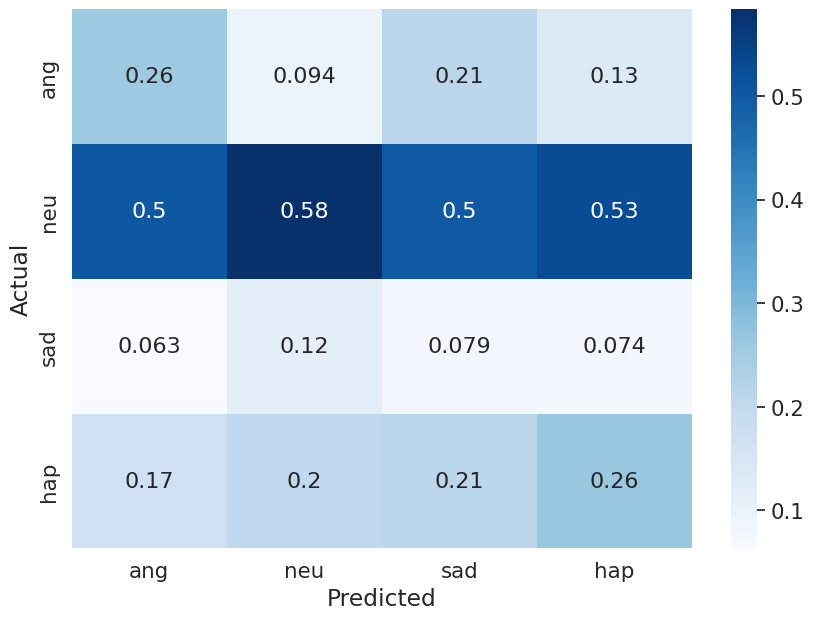

In [51]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

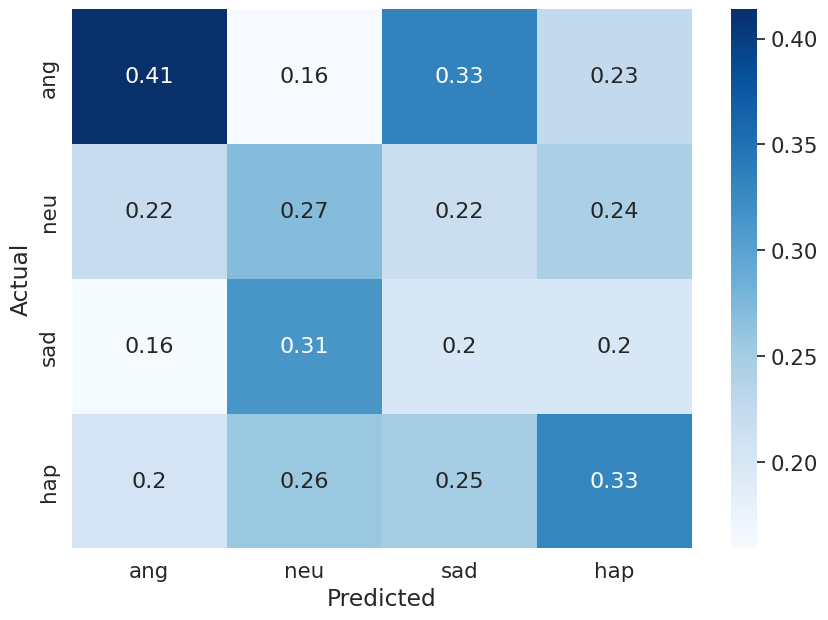

In [52]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [53]:
# Epoch 53: Correct: 685/1700 (0.4029)
me = {'acc_unweighted': torch.tensor(0.2844),
 'acc_weighted': torch.tensor(0.4029),
 'f1s_unweighted': torch.tensor(0.2864),
 'f1s_weighted': torch.tensor(0.4083),
 'rocauc': torch.tensor(0.5483),
 'uar': torch.tensor(0.2844),
 'wap': torch.tensor(0.4193)}
med = {'acc_detail': torch.tensor([0.1829, 0.5656, 0.1429, 0.2464]),
 'f1s_detail': torch.tensor([0.2260, 0.5761, 0.1214, 0.2222]),
 'precision_detail': torch.tensor([0.2956, 0.5869, 0.1055, 0.2024]),
 'recall_detail': torch.tensor([0.1829, 0.5656, 0.1429, 0.2464]),
 'rocauc_detail': torch.tensor([0.6243, 0.5356, 0.5289, 0.5045])}

cm = torch.tensor([[ 47, 106,  30,  74],
        [ 78, 530, 113, 216],
        [ 11,  82,  23,  45],
        [ 23, 185,  52,  85]])

pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.2844),
 'acc_weighted': tensor(0.4029),
 'f1s_unweighted': tensor(0.2864),
 'f1s_weighted': tensor(0.4083),
 'rocauc': tensor(0.5483),
 'uar': tensor(0.2844),
 'wap': tensor(0.4193)}
{'acc_detail': tensor([0.1829, 0.5656, 0.1429, 0.2464]),
 'f1s_detail': tensor([0.2260, 0.5761, 0.1214, 0.2222]),
 'precision_detail': tensor([0.2956, 0.5869, 0.1055, 0.2024]),
 'recall_detail': tensor([0.1829, 0.5656, 0.1429, 0.2464]),
 'rocauc_detail': tensor([0.6243, 0.5356, 0.5289, 0.5045])}
tensor([[ 47, 106,  30,  74],
        [ 78, 530, 113, 216],
        [ 11,  82,  23,  45],
        [ 23, 185,  52,  85]])


<Axes: xlabel='Predicted', ylabel='Actual'>

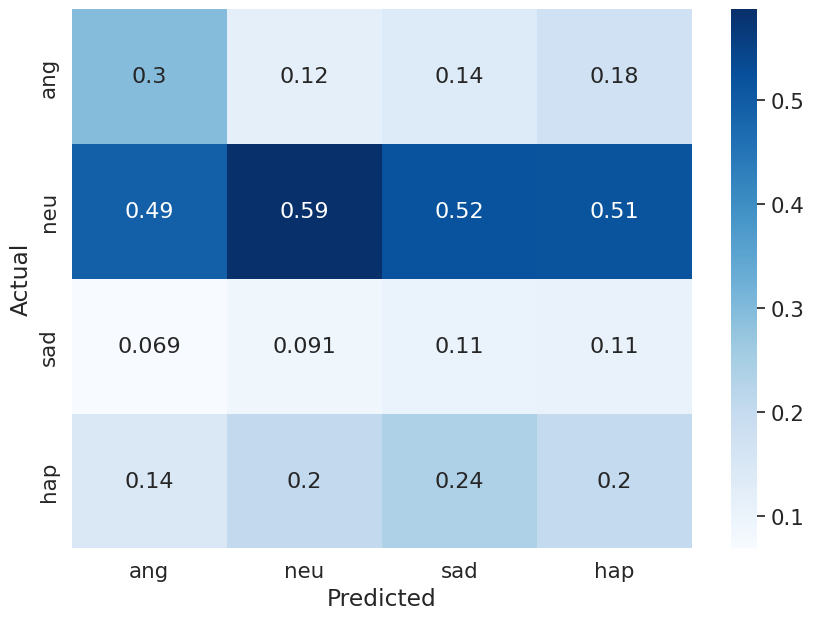

In [54]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

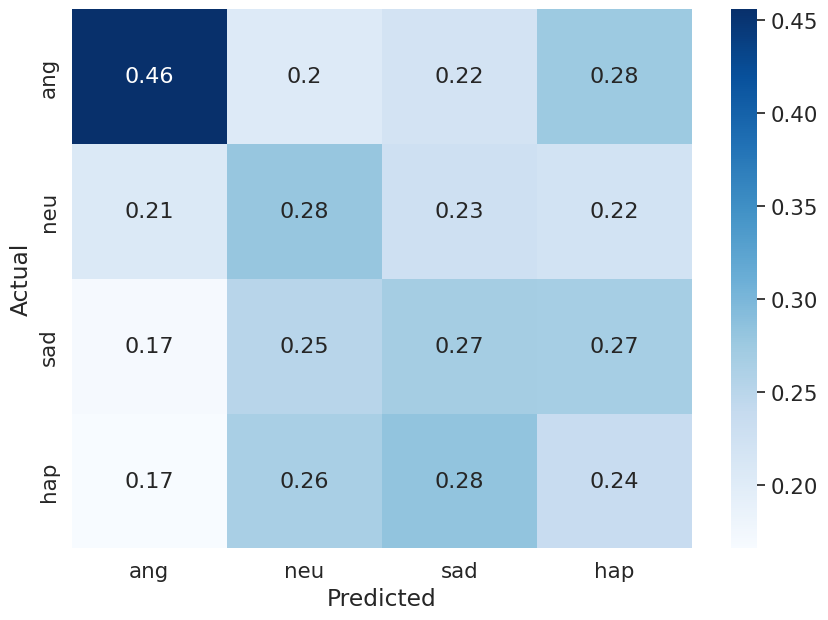

In [55]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [56]:
# Epoch 55: Correct: 679/1700 (0.3994)

me = {'acc_unweighted': torch.tensor(0.3044),
 'acc_weighted': torch.tensor(0.3994),
 'f1s_unweighted': torch.tensor(0.2976),
 'f1s_weighted': torch.tensor(0.4073),
 'rocauc': torch.tensor(0.5595),
 'uar': torch.tensor(0.3044),
 'wap': torch.tensor(0.4190)}
med = {'acc_detail': torch.tensor([0.3424, 0.5347, 0.1491, 0.1913]),
 'f1s_detail': torch.tensor([0.2973, 0.5604, 0.1297, 0.2031]),
 'precision_detail': torch.tensor([0.2627, 0.5887, 0.1148, 0.2164]),
 'recall_detail': torch.tensor([0.3424, 0.5347, 0.1491, 0.1913]),
 'rocauc_detail': torch.tensor([0.6208, 0.5446, 0.5515, 0.5210])}

cm = torch.tensor([[ 88,  90,  33,  46],
        [167, 501, 110, 159],
        [ 21,  82,  24,  34],
        [ 59, 178,  42,  66]])

pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.3044),
 'acc_weighted': tensor(0.3994),
 'f1s_unweighted': tensor(0.2976),
 'f1s_weighted': tensor(0.4073),
 'rocauc': tensor(0.5595),
 'uar': tensor(0.3044),
 'wap': tensor(0.4190)}
{'acc_detail': tensor([0.3424, 0.5347, 0.1491, 0.1913]),
 'f1s_detail': tensor([0.2973, 0.5604, 0.1297, 0.2031]),
 'precision_detail': tensor([0.2627, 0.5887, 0.1148, 0.2164]),
 'recall_detail': tensor([0.3424, 0.5347, 0.1491, 0.1913]),
 'rocauc_detail': tensor([0.6208, 0.5446, 0.5515, 0.5210])}
tensor([[ 88,  90,  33,  46],
        [167, 501, 110, 159],
        [ 21,  82,  24,  34],
        [ 59, 178,  42,  66]])


<Axes: xlabel='Predicted', ylabel='Actual'>

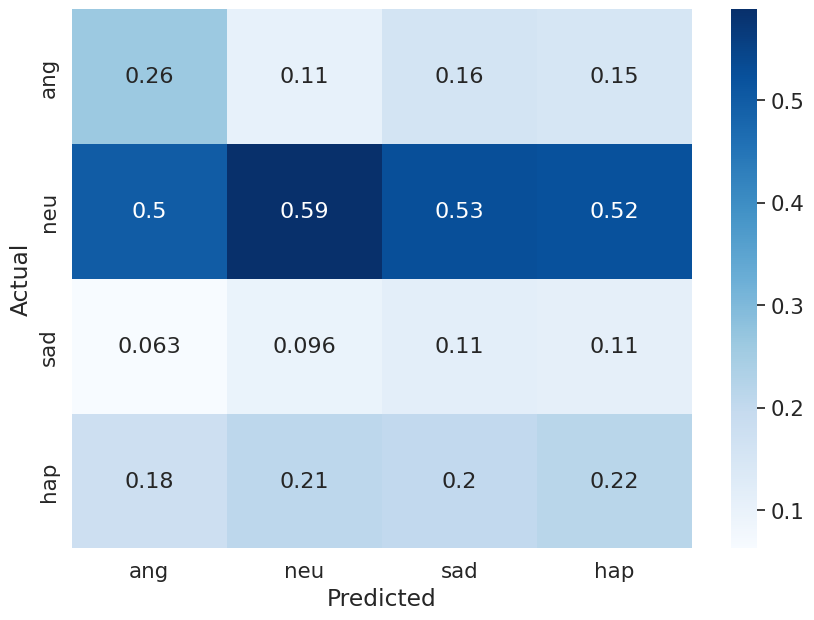

In [57]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

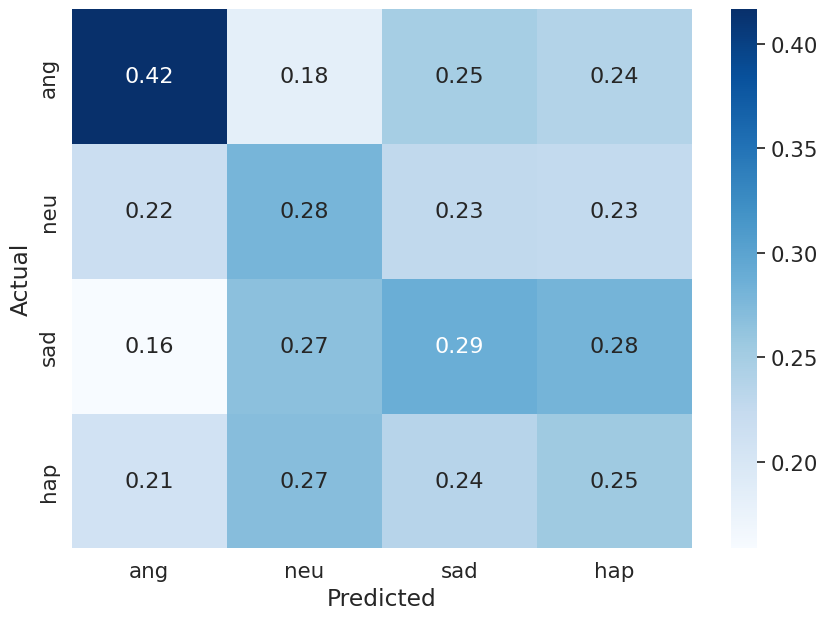

In [58]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [59]:
# Epoch 41: Correct: 586/1700 (0.3447)

me = {'acc_unweighted': torch.tensor(0.3030),
 'acc_weighted': torch.tensor(0.3447),
 'f1s_unweighted': torch.tensor(0.2870),
 'f1s_weighted': torch.tensor(0.3678),
 'rocauc': torch.tensor(0.5637),
 'uar': torch.tensor(0.3030),
 'wap': torch.tensor(0.4203)}
med = {'acc_detail': torch.tensor([0.3696, 0.3906, 0.1677, 0.2841]),
 'f1s_detail': torch.tensor([0.3025, 0.4710, 0.1247, 0.2497]),
 'precision_detail': torch.tensor([0.2561, 0.5932, 0.0993, 0.2227]),
 'recall_detail': torch.tensor([0.3696, 0.3906, 0.1677, 0.2841]),
 'rocauc_detail': torch.tensor([0.6381, 0.5489, 0.5501, 0.5176])}

cm = torch.tensor([[ 95,  70,  36,  56],
        [190, 366, 148, 233],
        [ 23,  58,  27,  53],
        [ 63, 123,  61,  98]])

pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.3030),
 'acc_weighted': tensor(0.3447),
 'f1s_unweighted': tensor(0.2870),
 'f1s_weighted': tensor(0.3678),
 'rocauc': tensor(0.5637),
 'uar': tensor(0.3030),
 'wap': tensor(0.4203)}
{'acc_detail': tensor([0.3696, 0.3906, 0.1677, 0.2841]),
 'f1s_detail': tensor([0.3025, 0.4710, 0.1247, 0.2497]),
 'precision_detail': tensor([0.2561, 0.5932, 0.0993, 0.2227]),
 'recall_detail': tensor([0.3696, 0.3906, 0.1677, 0.2841]),
 'rocauc_detail': tensor([0.6381, 0.5489, 0.5501, 0.5176])}
tensor([[ 95,  70,  36,  56],
        [190, 366, 148, 233],
        [ 23,  58,  27,  53],
        [ 63, 123,  61,  98]])


<Axes: xlabel='Predicted', ylabel='Actual'>

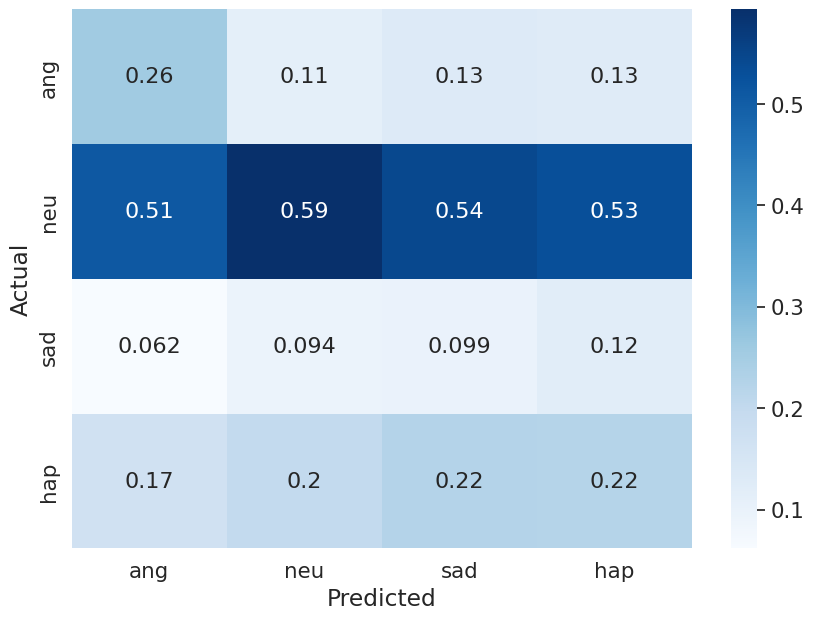

In [60]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

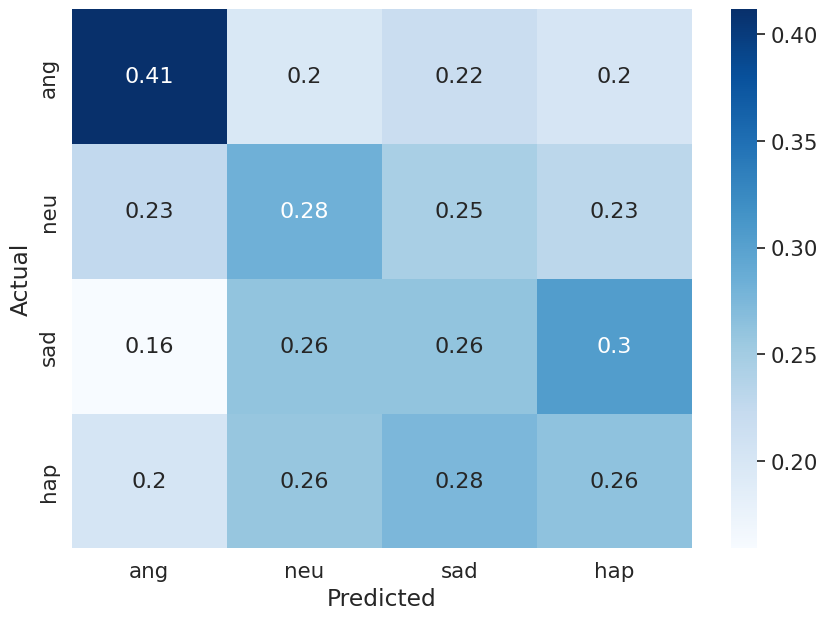

In [61]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [62]:
# Epoch 58: Correct: 511/1700 (0.3006)

me = {'acc_unweighted': torch.tensor(0.3112),
 'acc_weighted': torch.tensor(0.3006),
 'f1s_unweighted': torch.tensor(0.2727),
 'f1s_weighted': torch.tensor(0.3155),
 'rocauc': torch.tensor(0.5592),
 'uar': torch.tensor(0.3112),
 'wap': torch.tensor(0.4133)}
med = {'acc_detail': torch.tensor([0.4241, 0.2625, 0.1988, 0.3594]),
 'f1s_detail': torch.tensor([0.2962, 0.3618, 0.1531, 0.2799]),
 'precision_detail': torch.tensor([0.2276, 0.5816, 0.1245, 0.2292]),
 'recall_detail': torch.tensor([0.4241, 0.2625, 0.1988, 0.3594]),
 'rocauc_detail': torch.tensor([0.6166, 0.5388, 0.5525, 0.5291])}

cm = torch.tensor([[109,  50,  37,  61],
        [257, 246, 134, 300],
        [ 39,  34,  32,  56],
        [ 74,  93,  54, 124]])

pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.3112),
 'acc_weighted': tensor(0.3006),
 'f1s_unweighted': tensor(0.2727),
 'f1s_weighted': tensor(0.3155),
 'rocauc': tensor(0.5592),
 'uar': tensor(0.3112),
 'wap': tensor(0.4133)}
{'acc_detail': tensor([0.4241, 0.2625, 0.1988, 0.3594]),
 'f1s_detail': tensor([0.2962, 0.3618, 0.1531, 0.2799]),
 'precision_detail': tensor([0.2276, 0.5816, 0.1245, 0.2292]),
 'recall_detail': tensor([0.4241, 0.2625, 0.1988, 0.3594]),
 'rocauc_detail': tensor([0.6166, 0.5388, 0.5525, 0.5291])}
tensor([[109,  50,  37,  61],
        [257, 246, 134, 300],
        [ 39,  34,  32,  56],
        [ 74,  93,  54, 124]])


<Axes: xlabel='Predicted', ylabel='Actual'>

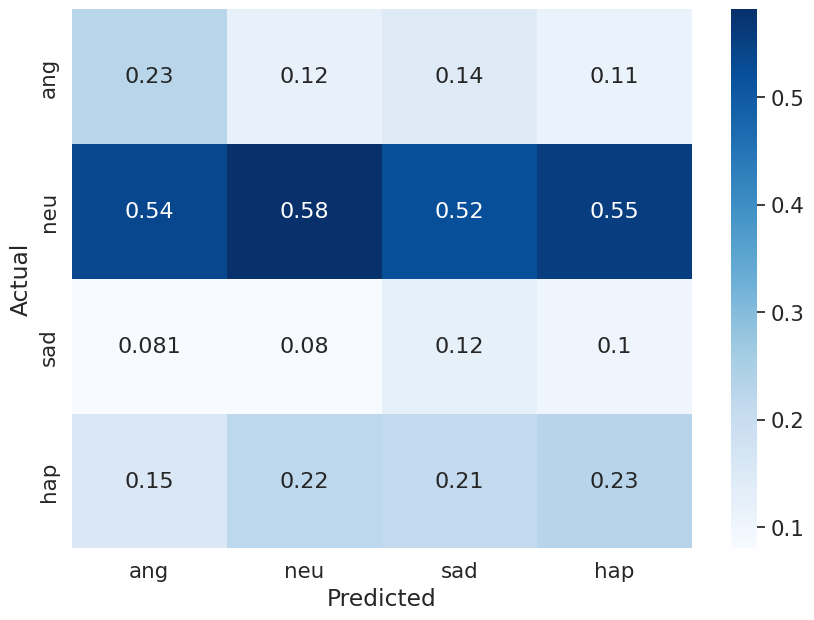

In [63]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

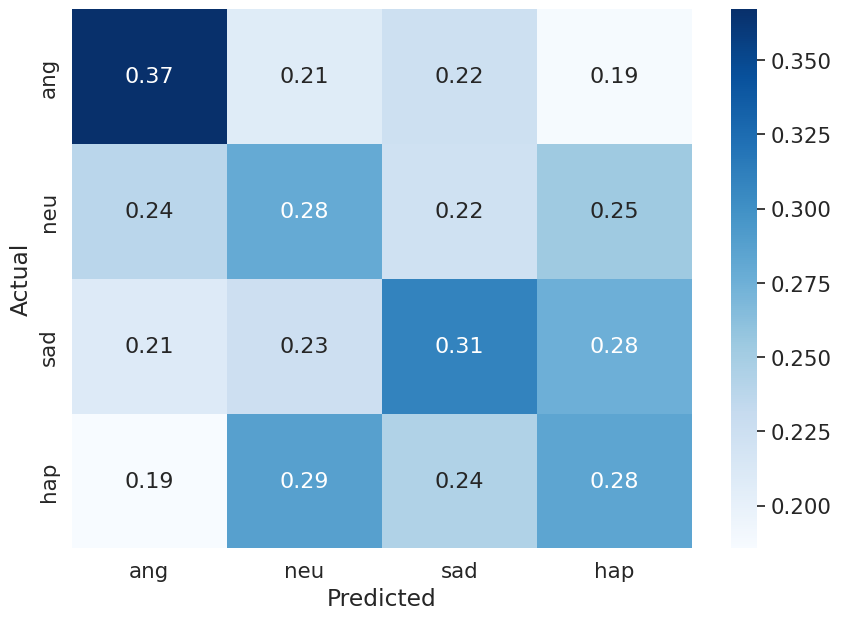

In [64]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [65]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

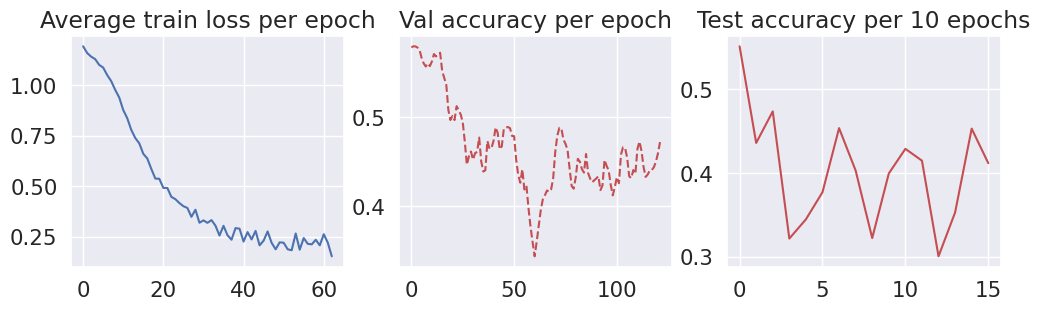

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [67]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': log_dir + "model.epoch=58.step=145310.pt"
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")

## Pretrained: ravdess

`./scb16_models/ravdess/run1/model.epoch=87.step=8669.test_acc=0.6519.pt`

In [68]:
pretrained_path = '../scb16_models/ravdess/run1/model.epoch=87.step=8669.test_acc=0.6519.pt'
trainer.load(pretrained_path)

In [69]:
metrics_ravdess, metrics_details_ravdess, confusion_matrix_ravdess = trainer.test_step()

Correct: 358/1700 (0.2106)


In [70]:
me_ravdess = metrics_ravdess.cpu().compute()
med_ravdess = metrics_details_ravdess.cpu().compute()
cm_ravdess = confusion_matrix_ravdess.cpu().compute()
pprint(me_ravdess)
pprint(med_ravdess)
pprint(cm_ravdess)

{'acc_unweighted': tensor(0.2501),
 'acc_weighted': tensor(0.2106),
 'f1s_unweighted': tensor(0.1721),
 'f1s_weighted': tensor(0.1674),
 'rocauc': tensor(0.5192),
 'uar': tensor(0.2501),
 'wap': tensor(0.3950)}
{'acc_detail': tensor([0.1362, 0.0747, 0.1056, 0.6841]),
 'f1s_detail': tensor([0.1230, 0.1326, 0.1122, 0.3207]),
 'precision_detail': tensor([0.1122, 0.5882, 0.1197, 0.2094]),
 'recall_detail': tensor([0.1362, 0.0747, 0.1056, 0.6841]),
 'rocauc_detail': tensor([0.4485, 0.5350, 0.5604, 0.5331])}
tensor([[ 35,  13,  22, 187],
        [177,  70,  83, 607],
        [ 33,  14,  17,  97],
        [ 67,  22,  20, 236]])


<Axes: xlabel='Predicted', ylabel='Actual'>

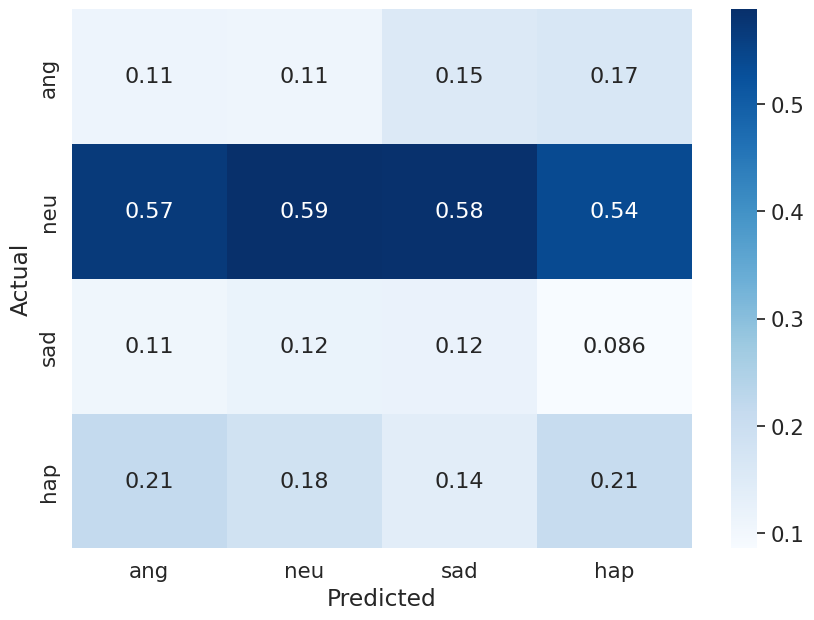

In [75]:
a = cm_ravdess
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

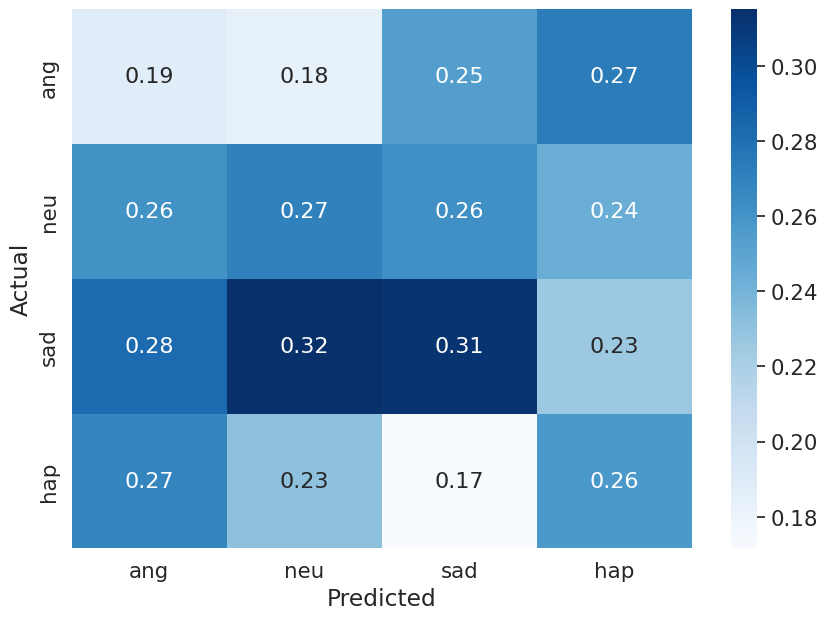

In [76]:
a = cm_ravdess
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

## pretrained: crema-d
`../scb16_models/crema_d/model.epoch=54.step=39304.test_acc=0.6408.pt`

In [73]:
pretrained_path = '../scb16_models/crema_d/model.epoch=54.step=39304.test_acc=0.6408.pt'
trainer.load(pretrained_path)

In [74]:
metrics_crema_d, metrics_details_crema_d, confusion_matrix_crema_d = trainer.test_step()

Correct: 580/1700 (0.3412)


In [81]:
me_crema_d = metrics_crema_d.cpu().compute()
med_crema_d = metrics_details_crema_d.cpu().compute()
cm_crema_d = confusion_matrix_crema_d.cpu().compute()
pprint(me_crema_d)
pprint(med_crema_d)
pprint(cm_crema_d)

{'acc_unweighted': tensor(0.2780),
 'acc_weighted': tensor(0.3412),
 'f1s_unweighted': tensor(0.2617),
 'f1s_weighted': tensor(0.3591),
 'rocauc': tensor(0.5530),
 'uar': tensor(0.2780),
 'wap': tensor(0.4080)}
{'acc_detail': tensor([0.4008, 0.4184, 0.0870, 0.2058]),
 'f1s_detail': tensor([0.2543, 0.4925, 0.1073, 0.1927]),
 'precision_detail': tensor([0.1863, 0.5985, 0.1400, 0.1811]),
 'recall_detail': tensor([0.4008, 0.4184, 0.0870, 0.2058]),
 'rocauc_detail': tensor([0.5925, 0.5494, 0.5725, 0.4976])}
tensor([[103,  72,   4,  78],
        [271, 392,  64, 210],
        [ 44,  70,  14,  33],
        [135, 121,  18,  71]])


<Axes: xlabel='Predicted', ylabel='Actual'>

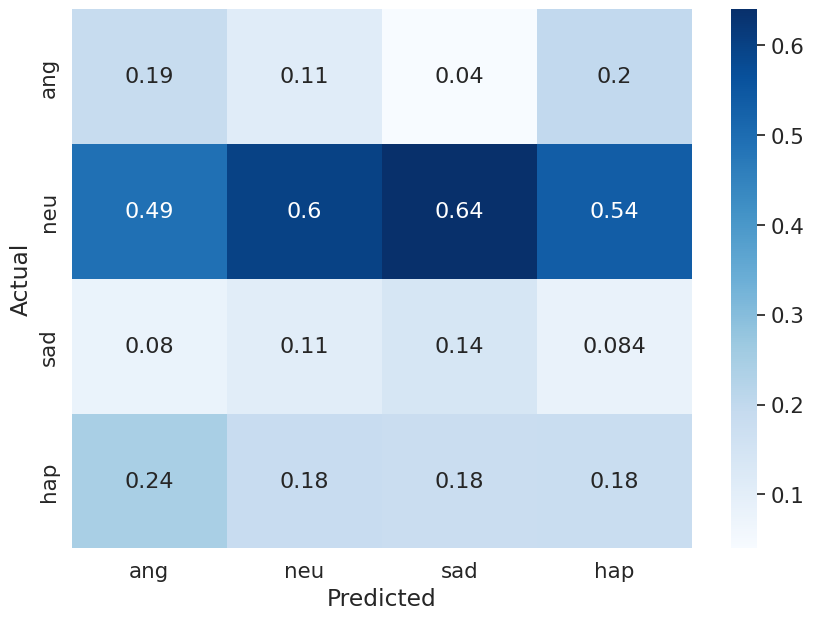

In [82]:
a = cm_crema_d
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

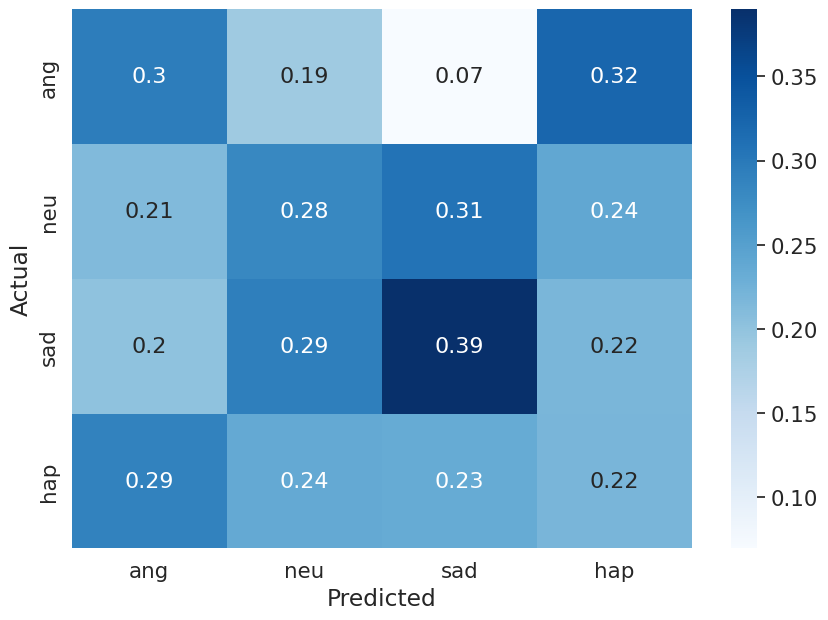

In [83]:
a = cm_crema_d
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

## pretrained: iemocap
`../scb16_models/iemocap/run1/model456.epoch=13.step=18501.loss=0.166.val_acc=0.594.pt`

In [85]:
pretrained_path = '../scb16_models/iemocap/run1/model456.epoch=13.step=18501.loss=0.166.val_acc=0.594.pt'
trainer.load(pretrained_path)

In [86]:
metrics_iemocap, metrics_details_iemocap, confusion_matrix_iemocap = trainer.test_step()

Correct: 639/1700 (0.3759)


In [87]:
me_iemocap = metrics_iemocap.cpu().compute()
med_iemocap = metrics_details_iemocap.cpu().compute()
cm_iemocap = confusion_matrix_iemocap.cpu().compute()
pprint(me_iemocap)
pprint(med_iemocap)
pprint(cm_iemocap)

{'acc_unweighted': tensor(0.2741),
 'acc_weighted': tensor(0.3759),
 'f1s_unweighted': tensor(0.2625),
 'f1s_weighted': tensor(0.3823),
 'rocauc': tensor(0.5414),
 'uar': tensor(0.2741),
 'wap': tensor(0.4034)}
{'acc_detail': tensor([0.2802, 0.4899, 0.0248, 0.3014]),
 'f1s_detail': tensor([0.2392, 0.5337, 0.0392, 0.2380]),
 'precision_detail': tensor([0.2087, 0.5862, 0.0930, 0.1966]),
 'recall_detail': tensor([0.2802, 0.4899, 0.0248, 0.3014]),
 'rocauc_detail': tensor([0.6150, 0.5401, 0.5197, 0.4909])}
tensor([[ 72,  69,   4, 112],
        [186, 459,  29, 263],
        [ 24,  83,   4,  50],
        [ 63, 172,   6, 104]])


<Axes: xlabel='Predicted', ylabel='Actual'>

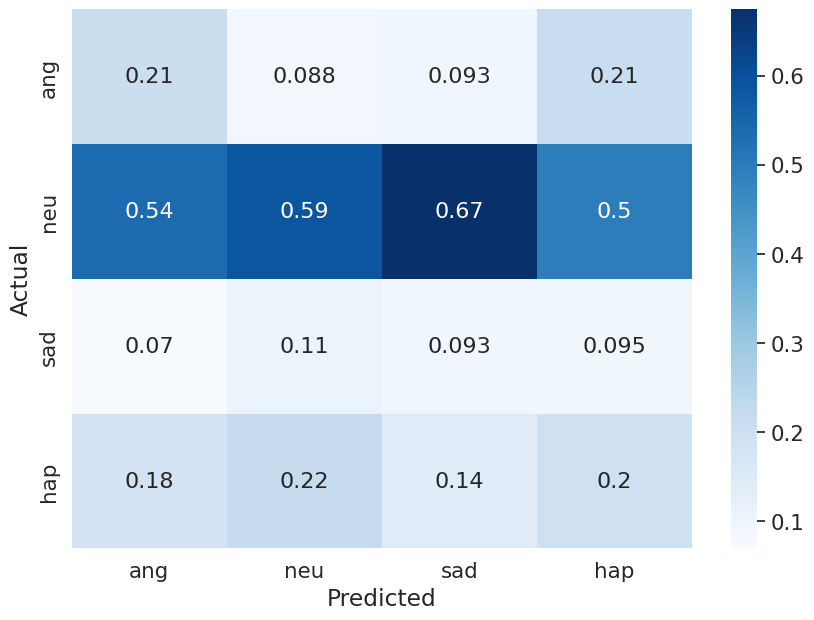

In [88]:
a = cm_iemocap
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

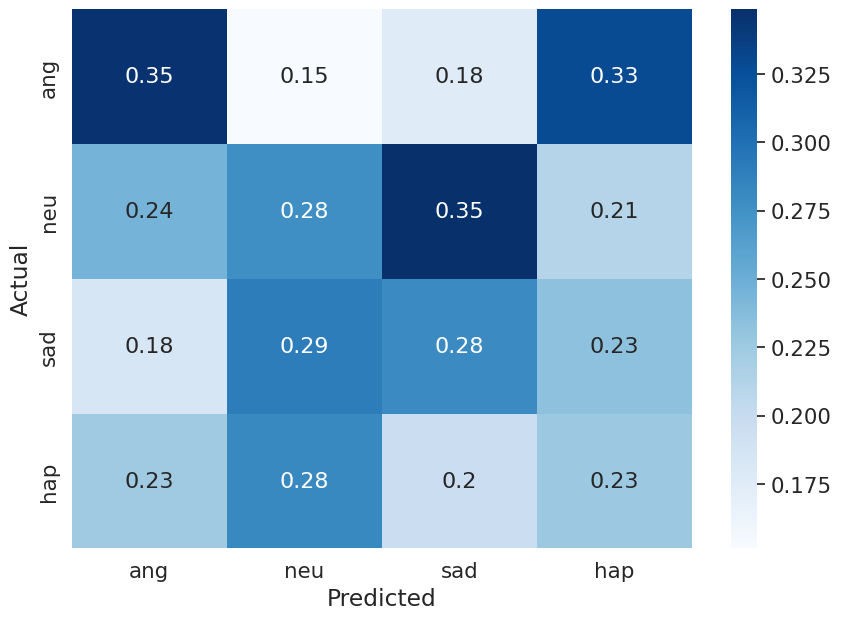

In [89]:
a = cm_iemocap
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [91]:
trainer.setup(trainer.model, lr=5e-5)

In [92]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run3/'
trainer.log_dir = log_dir
trainer.fit(
    n_epoch=60, self_supervised=False, 
    train_task='embedding', test_n_epoch=1, optimizer_with_regularizer=True)

  1%|▍                                                                            | 0.33339870562854323/60 [16:05<2550:31:45, 153886.85s/it]

Epoch: 1	Loss: 2.046 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.046]	Val_acc: 144/340 (42.35%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=1.step=1275.loss=2.046.val_acc=0.424.pt


  1%|▊                                                                             | 0.6666012943714613/60 [32:59<2503:32:51, 151900.47s/it]

Epoch: 1	Loss: 1.570 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.570]	Val_acc: 163/340 (47.94%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=1.step=2549.loss=1.570.val_acc=0.479.pt


  2%|█▎                                                                                | 1.0000000000000904/60 [43:24<30:31:32, 1862.59s/it]

Correct: 792/1700 (0.4659)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=1.step=2549.test_acc=0.4659.pt
{'acc_unweighted': tensor(0.2561),
 'acc_weighted': tensor(0.4659),
 'f1s_unweighted': tensor(0.2449),
 'f1s_weighted': tensor(0.4149),
 'rocauc': tensor(0.5362),
 'uar': tensor(0.2561),
 'wap': tensor(0.3890)}
{'acc_detail': tensor([0.0739, 0.7673, 0.0497, 0.1333]),
 'f1s_detail': tensor([0.1053, 0.6569, 0.0664, 0.1511]),
 'precision_detail': tensor([0.1827, 0.5743, 0.1000, 0.1742]),
 'recall_detail': tensor([0.0739, 0.7673, 0.0497, 0.1333]),
 'rocauc_detail': tensor([0.5761, 0.5360, 0.5348, 0.4978])}
tensor([[ 19, 159,   3,  76],
        [ 51, 719,  50, 117],
        [ 11, 117,   8,  25],
        [ 23, 257,  19,  46]])


  2%|█▋                                                                            | 1.3333987056287195/60 [59:56<2504:34:39, 153690.16s/it]

Epoch: 2	Loss: 1.095 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.095]	Val_acc: 186/340 (54.71%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=2.step=3824.loss=1.095.val_acc=0.547.pt


  3%|██                                                                          | 1.6666012943716848/60 [1:16:58<2491:29:51, 153760.82s/it]

Epoch: 2	Loss: 0.406 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.406]	Val_acc: 191/340 (56.18%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=2.step=5098.loss=0.406.val_acc=0.562.pt


  3%|██▋                                                                              | 2.000000000000314/60 [1:27:29<30:45:09, 1908.78s/it]

Correct: 887/1700 (0.5218)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=2.step=5098.test_acc=0.5218.pt
{'acc_unweighted': tensor(0.2501),
 'acc_weighted': tensor(0.5218),
 'f1s_unweighted': tensor(0.2049),
 'f1s_weighted': tensor(0.4044),
 'rocauc': tensor(0.5429),
 'uar': tensor(0.2501),
 'wap': tensor(0.3904)}
{'acc_detail': tensor([0.0117, 0.9189, 0.0062, 0.0638]),
 'f1s_detail': tensor([0.0224, 0.6905, 0.0113, 0.0954]),
 'precision_detail': tensor([0.2727, 0.5530, 0.0625, 0.1897]),
 'recall_detail': tensor([0.0117, 0.9189, 0.0062, 0.0638]),
 'rocauc_detail': tensor([0.6049, 0.5492, 0.5224, 0.4954])}
tensor([[  3, 221,   1,  32],
        [  7, 861,  10,  59],
        [  0, 157,   1,   3],
        [  1, 318,   4,  22]])


  4%|██▉                                                                         | 2.3333987056285657/60 [1:44:31<2492:06:55, 155577.32s/it]

Epoch: 3	Loss: 0.884 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.884]	Val_acc: 191/340 (56.18%)



  4%|███▍                                                                        | 2.6666012943711537/60 [2:01:29<2459:12:45, 154415.50s/it]

Epoch: 3	Loss: 0.914 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.914]	Val_acc: 193/340 (56.76%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=3.step=7647.loss=0.914.val_acc=0.568.pt


  5%|███▉                                                                            | 2.9999999999994054/60 [2:12:04<30:07:03, 1902.17s/it]

Correct: 912/1700 (0.5365)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=3.step=7647.test_acc=0.5365.pt
{'acc_unweighted': tensor(0.2547),
 'acc_weighted': tensor(0.5365),
 'f1s_unweighted': tensor(0.2040),
 'f1s_weighted': tensor(0.4067),
 'rocauc': tensor(0.5418),
 'uar': tensor(0.2547),
 'wap': tensor(0.4147)}
{'acc_detail': tensor([0.0078, 0.9498, 0.0062, 0.0551]),
 'f1s_detail': tensor([0.0152, 0.6983, 0.0120, 0.0905]),
 'precision_detail': tensor([0.2857, 0.5521, 0.1667, 0.2533]),
 'recall_detail': tensor([0.0078, 0.9498, 0.0062, 0.0551]),
 'rocauc_detail': tensor([0.6065, 0.5511, 0.5143, 0.4953])}
tensor([[  2, 239,   0,  16],
        [  5, 890,   4,  38],
        [  0, 158,   1,   2],
        [  0, 325,   1,  19]])


  6%|████▎                                                                        | 3.333398705627657/60 [2:29:02<2420:24:56, 153767.77s/it]

Epoch: 4	Loss: 0.740 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.740]	Val_acc: 195/340 (57.35%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=4.step=8922.loss=0.740.val_acc=0.574.pt


  6%|████▋                                                                        | 3.666601294370245/60 [2:46:02<2414:22:07, 154290.84s/it]

Epoch: 4	Loss: 0.961 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.961]	Val_acc: 192/340 (56.47%)



  7%|█████▎                                                                          | 3.9999999999984968/60 [2:56:38<30:21:03, 1951.13s/it]

Correct: 919/1700 (0.5406)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=4.step=10196.test_acc=0.5406.pt
{'acc_unweighted': tensor(0.2516),
 'acc_weighted': tensor(0.5406),
 'f1s_unweighted': tensor(0.1933),
 'f1s_weighted': tensor(0.4005),
 'rocauc': tensor(0.5423),
 'uar': tensor(0.2516),
 'wap': tensor(0.3985)}
{'acc_detail': tensor([0.0078, 0.9669, 0.0000, 0.0319]),
 'f1s_detail': tensor([0.0152, 0.7015, 0.0000, 0.0567]),
 'precision_detail': tensor([0.2857, 0.5504, 0.0000, 0.2558]),
 'recall_detail': tensor([0.0078, 0.9669, 0.0000, 0.0319]),
 'rocauc_detail': tensor([0.6149, 0.5487, 0.5120, 0.4936])}
tensor([[  2, 246,   0,   9],
        [  5, 906,   4,  22],
        [  0, 160,   0,   1],
        [  0, 334,   0,  11]])


  7%|█████▌                                                                       | 4.333398705626749/60 [3:13:36<2412:22:47, 156010.37s/it]

Epoch: 5	Loss: 0.564 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.564]	Val_acc: 195/340 (57.35%)



  8%|█████▉                                                                       | 4.666601294369337/60 [3:30:43<2365:54:17, 153926.16s/it]

Epoch: 5	Loss: 1.076 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.076]	Val_acc: 194/340 (57.06%)



  8%|██████▋                                                                          | 4.999999999997589/60 [3:41:19<29:11:51, 1911.12s/it]

Correct: 924/1700 (0.5435)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=5.step=12745.test_acc=0.5435.pt
{'acc_unweighted': tensor(0.2482),
 'acc_weighted': tensor(0.5435),
 'f1s_unweighted': tensor(0.1807),
 'f1s_weighted': tensor(0.3915),
 'rocauc': tensor(0.5490),
 'uar': tensor(0.2482),
 'wap': tensor(0.3664)}
{'acc_detail': tensor([0.0039, 0.9829, 0.0000, 0.0058]),
 'f1s_detail': tensor([0.0076, 0.7041, 0.0000, 0.0112]),
 'precision_detail': tensor([0.2000, 0.5485, 0.0000, 0.1667]),
 'recall_detail': tensor([0.0039, 0.9829, 0.0000, 0.0058]),
 'rocauc_detail': tensor([0.6381, 0.5534, 0.5083, 0.4965])}
tensor([[  1, 255,   0,   1],
        [  4, 921,   4,   8],
        [  0, 160,   0,   1],
        [  0, 343,   0,   2]])


  9%|██████▉                                                                       | 5.33339870562584/60 [3:58:29<2384:22:41, 157020.21s/it]

Epoch: 6	Loss: 1.078 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.078]	Val_acc: 196/340 (57.65%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=6.step=14020.loss=1.078.val_acc=0.576.pt


  9%|███████▎                                                                     | 5.666601294368428/60 [4:15:30<2377:38:01, 157536.27s/it]

Epoch: 6	Loss: 1.784 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.784]	Val_acc: 195/340 (57.35%)



 10%|████████▏                                                                         | 5.99999999999668/60 [4:26:12<28:47:35, 1919.55s/it]

Correct: 927/1700 (0.5453)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=6.step=15294.test_acc=0.5453.pt
{'acc_unweighted': tensor(0.2490),
 'acc_weighted': tensor(0.5453),
 'f1s_unweighted': tensor(0.1811),
 'f1s_weighted': tensor(0.3922),
 'rocauc': tensor(0.5479),
 'uar': tensor(0.2490),
 'wap': tensor(0.3836)}
{'acc_detail': tensor([0.0039, 0.9861, 0.0000, 0.0058]),
 'f1s_detail': tensor([0.0076, 0.7053, 0.0000, 0.0113]),
 'precision_detail': tensor([0.2000, 0.5490, 0.0000, 0.2500]),
 'recall_detail': tensor([0.0039, 0.9861, 0.0000, 0.0058]),
 'rocauc_detail': tensor([0.6314, 0.5455, 0.5195, 0.4953])}
tensor([[  1, 256,   0,   0],
        [  4, 924,   4,   5],
        [  0, 160,   0,   1],
        [  0, 343,   0,   2]])


 11%|████████▏                                                                    | 6.333398705624932/60 [4:43:19<2309:42:52, 154937.56s/it]

Epoch: 7	Loss: 0.621 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.621]	Val_acc: 196/340 (57.65%)



 11%|████████▋                                                                     | 6.66660129436752/60 [5:00:30<2314:48:25, 156249.28s/it]

Epoch: 7	Loss: 1.335 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.335]	Val_acc: 196/340 (57.65%)



 12%|█████████▍                                                                       | 6.999999999995771/60 [5:11:14<28:22:39, 1927.55s/it]

Correct: 929/1700 (0.5465)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=7.step=17843.test_acc=0.5465.pt
{'acc_unweighted': tensor(0.2495),
 'acc_weighted': tensor(0.5465),
 'f1s_unweighted': tensor(0.1813),
 'f1s_weighted': tensor(0.3928),
 'rocauc': tensor(0.5487),
 'uar': tensor(0.2495),
 'wap': tensor(0.3914)}
{'acc_detail': tensor([0.0039, 0.9883, 0.0000, 0.0058]),
 'f1s_detail': tensor([0.0077, 0.7063, 0.0000, 0.0113]),
 'precision_detail': tensor([0.2500, 0.5496, 0.0000, 0.2500]),
 'recall_detail': tensor([0.0039, 0.9883, 0.0000, 0.0058]),
 'rocauc_detail': tensor([0.6429, 0.5472, 0.5078, 0.4970])}
tensor([[  1, 256,   0,   0],
        [  3, 926,   3,   5],
        [  0, 160,   0,   1],
        [  0, 343,   0,   2]])


 12%|█████████▍                                                                   | 7.333398705624023/60 [5:28:22<2279:37:42, 155822.90s/it]

Epoch: 8	Loss: 1.519 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.519]	Val_acc: 196/340 (57.65%)



 13%|█████████▊                                                                   | 7.666601294366611/60 [5:45:29<2273:11:23, 156372.10s/it]

Epoch: 8	Loss: 0.961 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.961]	Val_acc: 196/340 (57.65%)



 13%|██████████▊                                                                      | 7.999999999994863/60 [5:56:14<27:55:33, 1933.33s/it]

Correct: 931/1700 (0.5476)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=8.step=20392.test_acc=0.5476.pt
{'acc_unweighted': tensor(0.2500),
 'acc_weighted': tensor(0.5476),
 'f1s_unweighted': tensor(0.1816),
 'f1s_weighted': tensor(0.3933),
 'rocauc': tensor(0.5513),
 'uar': tensor(0.2500),
 'wap': tensor(0.4043)}
{'acc_detail': tensor([0.0039, 0.9904, 0.0000, 0.0058]),
 'f1s_detail': tensor([0.0077, 0.7073, 0.0000, 0.0113]),
 'precision_detail': tensor([0.3333, 0.5501, 0.0000, 0.2500]),
 'recall_detail': tensor([0.0039, 0.9904, 0.0000, 0.0058]),
 'rocauc_detail': tensor([0.6477, 0.5468, 0.5081, 0.5024])}
tensor([[  1, 256,   0,   0],
        [  2, 928,   2,   5],
        [  0, 160,   0,   1],
        [  0, 343,   0,   2]])


 14%|██████████▋                                                                  | 8.333398705624624/60 [6:13:25<2245:44:05, 156477.22s/it]

Epoch: 9	Loss: 1.404 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.404]	Val_acc: 196/340 (57.65%)



 14%|███████████                                                                  | 8.666601294368721/60 [6:30:33<2232:25:21, 156559.31s/it]

Epoch: 9	Loss: 1.102 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.102]	Val_acc: 196/340 (57.65%)



 15%|████████████▏                                                                    | 8.999999999998483/60 [6:41:21<27:26:42, 1937.31s/it]

Correct: 930/1700 (0.5471)
{'acc_unweighted': tensor(0.2502),
 'acc_weighted': tensor(0.5471),
 'f1s_unweighted': tensor(0.1828),
 'f1s_weighted': tensor(0.3941),
 'rocauc': tensor(0.5508),
 'uar': tensor(0.2502),
 'wap': tensor(0.4044)}
{'acc_detail': tensor([0.0039, 0.9883, 0.0000, 0.0087]),
 'f1s_detail': tensor([0.0076, 0.7066, 0.0000, 0.0170]),
 'precision_detail': tensor([0.1667, 0.5499, 0.0000, 0.3750]),
 'recall_detail': tensor([0.0039, 0.9883, 0.0000, 0.0087]),
 'rocauc_detail': tensor([0.6462, 0.5406, 0.5094, 0.5070])}
tensor([[  1, 256,   0,   0],
        [  5, 926,   2,   4],
        [  0, 160,   0,   1],
        [  0, 342,   0,   3]])


 16%|███████████▉                                                                 | 9.333398705628245/60 [6:58:33<2210:11:04, 157039.63s/it]

Epoch: 10	Loss: 1.043 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.043]	Val_acc: 196/340 (57.65%)



 16%|████████████▍                                                                | 9.666601294372342/60 [7:15:45<2180:29:20, 155955.31s/it]

Epoch: 10	Loss: 0.721 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.721]	Val_acc: 196/340 (57.65%)



 17%|█████████████▎                                                                  | 10.000000000002103/60 [7:26:34<26:56:57, 1940.34s/it]

Correct: 933/1700 (0.5488)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=10.step=25490.test_acc=0.5488.pt
{'acc_unweighted': tensor(0.2506),
 'acc_weighted': tensor(0.5488),
 'f1s_unweighted': tensor(0.1818),
 'f1s_weighted': tensor(0.3939),
 'rocauc': tensor(0.5559),
 'uar': tensor(0.2506),
 'wap': tensor(0.4302)}
{'acc_detail': tensor([0.0039, 0.9925, 0.0000, 0.0058]),
 'f1s_detail': tensor([0.0076, 0.7083, 0.0000, 0.0115]),
 'precision_detail': tensor([0.1667, 0.5506, 0.0000, 0.5000]),
 'recall_detail': tensor([0.0039, 0.9925, 0.0000, 0.0058]),
 'rocauc_detail': tensor([0.6533, 0.5416, 0.5163, 0.5124])}
tensor([[  1, 256,   0,   0],
        [  4, 930,   1,   2],
        [  1, 160,   0,   0],
        [  0, 343,   0,   2]])


 17%|█████████████                                                               | 10.333398705631865/60 [7:43:54<2155:50:58, 156263.13s/it]

Epoch: 11	Loss: 0.652 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.652]	Val_acc: 196/340 (57.65%)



 18%|█████████████▌                                                              | 10.666601294375962/60 [8:01:03<2161:12:55, 157710.10s/it]

Epoch: 11	Loss: 1.032 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.032]	Val_acc: 196/340 (57.65%)



 18%|██████████████▋                                                                 | 11.000000000005723/60 [8:11:55<26:30:13, 1947.21s/it]

Correct: 934/1700 (0.5494)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=11.step=28039.test_acc=0.5494.pt
{'acc_unweighted': tensor(0.2504),
 'acc_weighted': tensor(0.5494),
 'f1s_unweighted': tensor(0.1806),
 'f1s_weighted': tensor(0.3931),
 'rocauc': tensor(0.5633),
 'uar': tensor(0.2504),
 'wap': tensor(0.4015)}
{'acc_detail': tensor([0.0039, 0.9947, 0.0000, 0.0029]),
 'f1s_detail': tensor([0.0076, 0.7090, 0.0000, 0.0057]),
 'precision_detail': tensor([0.2000, 0.5508, 0.0000, 0.3333]),
 'recall_detail': tensor([0.0039, 0.9947, 0.0000, 0.0029]),
 'rocauc_detail': tensor([0.6606, 0.5510, 0.5165, 0.5250])}
tensor([[  1, 256,   0,   0],
        [  3, 932,   0,   2],
        [  1, 160,   0,   0],
        [  0, 344,   0,   1]])


 19%|██████████████▎                                                             | 11.333398705635485/60 [8:29:13<2133:46:01, 157840.51s/it]

Epoch: 12	Loss: 0.523 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.523]	Val_acc: 196/340 (57.65%)



 19%|██████████████▊                                                             | 11.666601294379582/60 [8:46:28<2101:39:30, 156537.12s/it]

Epoch: 12	Loss: 0.586 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.586]	Val_acc: 196/340 (57.65%)



 20%|████████████████                                                                | 12.000000000009344/60 [8:57:22<26:14:17, 1967.87s/it]

Correct: 933/1700 (0.5488)
{'acc_unweighted': tensor(0.2501),
 'acc_weighted': tensor(0.5488),
 'f1s_unweighted': tensor(0.1805),
 'f1s_weighted': tensor(0.3928),
 'rocauc': tensor(0.5639),
 'uar': tensor(0.2501),
 'wap': tensor(0.3963)}
{'acc_detail': tensor([0.0039, 0.9936, 0.0000, 0.0029]),
 'f1s_detail': tensor([0.0076, 0.7085, 0.0000, 0.0057]),
 'precision_detail': tensor([0.1667, 0.5506, 0.0000, 0.3333]),
 'recall_detail': tensor([0.0039, 0.9936, 0.0000, 0.0029]),
 'rocauc_detail': tensor([0.6609, 0.5501, 0.5163, 0.5282])}
tensor([[  1, 256,   0,   0],
        [  4, 931,   0,   2],
        [  1, 160,   0,   0],
        [  0, 344,   0,   1]])


 21%|███████████████▌                                                            | 12.333398705639105/60 [9:14:36<2081:25:52, 157199.23s/it]

Epoch: 13	Loss: 0.474 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.474]	Val_acc: 197/340 (57.94%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=13.step=31863.loss=0.474.val_acc=0.579.pt


 21%|████████████████                                                            | 12.666601294383202/60 [9:31:57<2052:42:17, 156121.00s/it]

Epoch: 13	Loss: 1.531 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.531]	Val_acc: 195/340 (57.35%)



 22%|█████████████████▎                                                              | 13.000000000012964/60 [9:42:52<25:30:27, 1953.77s/it]

Correct: 932/1700 (0.5482)
{'acc_unweighted': tensor(0.2494),
 'acc_weighted': tensor(0.5482),
 'f1s_unweighted': tensor(0.1790),
 'f1s_weighted': tensor(0.3915),
 'rocauc': tensor(0.5713),
 'uar': tensor(0.2494),
 'wap': tensor(0.3285)}
{'acc_detail': tensor([0.0039, 0.9936, 0.0000, 0.0000]),
 'f1s_detail': tensor([0.0076, 0.7083, 0.0000, 0.0000]),
 'precision_detail': tensor([0.1667, 0.5502, 0.0000, 0.0000]),
 'recall_detail': tensor([0.0039, 0.9936, 0.0000, 0.0000]),
 'rocauc_detail': tensor([0.6677, 0.5526, 0.5198, 0.5450])}
tensor([[  1, 256,   0,   0],
        [  4, 931,   0,   2],
        [  1, 160,   0,   0],
        [  0, 345,   0,   0]])


 22%|████████████████▋                                                          | 13.333398705642725/60 [10:00:17<2039:25:19, 157327.06s/it]

Epoch: 14	Loss: 1.518 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.518]	Val_acc: 195/340 (57.35%)



 23%|█████████████████                                                          | 13.666601294386822/60 [10:17:17<1969:59:32, 153063.93s/it]

Epoch: 14	Loss: 1.979 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.979]	Val_acc: 196/340 (57.65%)



 23%|██████████████████▍                                                            | 14.000000000016584/60 [10:28:24<25:31:30, 1997.62s/it]

Correct: 932/1700 (0.5482)
{'acc_unweighted': tensor(0.2508),
 'acc_weighted': tensor(0.5482),
 'f1s_unweighted': tensor(0.1826),
 'f1s_weighted': tensor(0.3937),
 'rocauc': tensor(0.5693),
 'uar': tensor(0.2508),
 'wap': tensor(0.3489)}
{'acc_detail': tensor([0.0117, 0.9915, 0.0000, 0.0000]),
 'f1s_detail': tensor([0.0225, 0.7081, 0.0000, 0.0000]),
 'precision_detail': tensor([0.3000, 0.5507, 0.0000, 0.0000]),
 'recall_detail': tensor([0.0117, 0.9915, 0.0000, 0.0000]),
 'rocauc_detail': tensor([0.6653, 0.5521, 0.5093, 0.5507])}
tensor([[  3, 254,   0,   0],
        [  5, 929,   0,   3],
        [  1, 160,   0,   0],
        [  1, 344,   0,   0]])


 24%|█████████████████▉                                                         | 14.333398705646346/60 [10:45:09<1933:39:28, 152434.56s/it]

Epoch: 15	Loss: 1.503 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.503]	Val_acc: 196/340 (57.65%)



 24%|██████████████████▎                                                        | 14.666601294390443/60 [11:01:38<1925:49:05, 152932.39s/it]

Epoch: 15	Loss: 0.973 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.973]	Val_acc: 196/340 (57.65%)



 25%|███████████████████▊                                                           | 15.000000000020204/60 [11:12:38<24:29:38, 1959.52s/it]

Correct: 931/1700 (0.5476)
{'acc_unweighted': tensor(0.2505),
 'acc_weighted': tensor(0.5476),
 'f1s_unweighted': tensor(0.1825),
 'f1s_weighted': tensor(0.3934),
 'rocauc': tensor(0.5762),
 'uar': tensor(0.2505),
 'wap': tensor(0.3487)}
{'acc_detail': tensor([0.0117, 0.9904, 0.0000, 0.0000]),
 'f1s_detail': tensor([0.0225, 0.7076, 0.0000, 0.0000]),
 'precision_detail': tensor([0.3000, 0.5504, 0.0000, 0.0000]),
 'recall_detail': tensor([0.0117, 0.9904, 0.0000, 0.0000]),
 'rocauc_detail': tensor([0.6722, 0.5570, 0.5160, 0.5594])}
tensor([[  3, 254,   0,   0],
        [  5, 928,   0,   4],
        [  1, 160,   0,   0],
        [  1, 344,   0,   0]])


 26%|███████████████████▏                                                       | 15.333398705649966/60 [11:29:20<1893:02:11, 152573.32s/it]

Epoch: 16	Loss: 1.557 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.557]	Val_acc: 194/340 (57.06%)



 26%|████████████████████▏                                                          | 15.339086095334238/60 [11:29:36<33:27:50, 2697.45s/it]

KeyboardInterrupt



In [93]:
trainer.fit(
    n_epoch=10, self_supervised=False, lr=1e-3,
    train_task='embedding', test_n_epoch=1, optimizer_with_regularizer=True)

  3%|██▌                                                                           | 0.33339870562854323/10 [17:08<424:54:01, 158239.84s/it]

Epoch: 17	Loss: 0.868 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.868]	Val_acc: 197/340 (57.94%)



  7%|█████▎                                                                         | 0.6666012943714613/10 [34:34<412:10:25, 158980.20s/it]

Epoch: 17	Loss: 1.432 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.432]	Val_acc: 198/340 (58.24%)

Saved new best val model: ../scb16_models/meld/run3/model.epoch=17.step=42081.loss=1.432.val_acc=0.582.pt


 10%|████████▎                                                                          | 1.0000000000000904/10 [45:37<4:59:21, 1995.70s/it]

Correct: 937/1700 (0.5512)
Saved new best test model: ../scb16_models/meld/run3/model.epoch=17.step=42081.test_acc=0.5512.pt
{'acc_unweighted': tensor(0.2507),
 'acc_weighted': tensor(0.5512),
 'f1s_unweighted': tensor(0.1795),
 'f1s_weighted': tensor(0.3927),
 'rocauc': tensor(0.5709),
 'uar': tensor(0.2507),
 'wap': tensor(0.3794)}
{'acc_detail': tensor([0.0039, 0.9989, 0.0000, 0.0000]),
 'f1s_detail': tensor([0.0077, 0.7104, 0.0000, 0.0000]),
 'precision_detail': tensor([0.5000, 0.5512, 0.0000, 0.0000]),
 'recall_detail': tensor([0.0039, 0.9989, 0.0000, 0.0000]),
 'rocauc_detail': tensor([0.6635, 0.5527, 0.5296, 0.5378])}
tensor([[  1, 256,   0,   0],
        [  1, 936,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


 13%|██████████▎                                                                  | 1.3333987056287195/10 [1:03:08<387:50:36, 161105.44s/it]

Epoch: 18	Loss: 0.866 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.866]	Val_acc: 197/340 (57.94%)



 17%|████████████▊                                                                | 1.6666012943716848/10 [1:20:41<370:31:49, 160067.83s/it]

Epoch: 18	Loss: 1.390 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.390]	Val_acc: 197/340 (57.94%)



 20%|████████████████▍                                                                 | 2.000000000000314/10 [1:31:53<4:26:26, 1998.28s/it]

Correct: 936/1700 (0.5506)
{'acc_unweighted': tensor(0.2504),
 'acc_weighted': tensor(0.5506),
 'f1s_unweighted': tensor(0.1794),
 'f1s_weighted': tensor(0.3925),
 'rocauc': tensor(0.5546),
 'uar': tensor(0.2504),
 'wap': tensor(0.3793)}
{'acc_detail': tensor([0.0039, 0.9979, 0.0000, 0.0000]),
 'f1s_detail': tensor([0.0077, 0.7099, 0.0000, 0.0000]),
 'precision_detail': tensor([0.5000, 0.5510, 0.0000, 0.0000]),
 'recall_detail': tensor([0.0039, 0.9979, 0.0000, 0.0000]),
 'rocauc_detail': tensor([0.6536, 0.5520, 0.4829, 0.5300])}
tensor([[  1, 256,   0,   0],
        [  1, 935,   0,   1],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


 23%|█████████████████▉                                                           | 2.3333987056285657/10 [1:49:33<337:26:14, 158450.26s/it]

Epoch: 19	Loss: 0.723 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.723]	Val_acc: 198/340 (58.24%)



 27%|████████████████████▌                                                        | 2.6666012943711537/10 [2:07:06<326:43:59, 160394.82s/it]

Epoch: 19	Loss: 1.534 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.534]	Val_acc: 197/340 (57.94%)



 30%|████████████████████████▎                                                        | 2.9999999999994054/10 [2:18:20<3:55:17, 2016.84s/it]

Correct: 936/1700 (0.5506)
{'acc_unweighted': tensor(0.2504),
 'acc_weighted': tensor(0.5506),
 'f1s_unweighted': tensor(0.1794),
 'f1s_weighted': tensor(0.3925),
 'rocauc': tensor(0.5635),
 'uar': tensor(0.2504),
 'wap': tensor(0.3793)}
{'acc_detail': tensor([0.0039, 0.9979, 0.0000, 0.0000]),
 'f1s_detail': tensor([0.0077, 0.7099, 0.0000, 0.0000]),
 'precision_detail': tensor([0.5000, 0.5510, 0.0000, 0.0000]),
 'recall_detail': tensor([0.0039, 0.9979, 0.0000, 0.0000]),
 'rocauc_detail': tensor([0.6696, 0.5592, 0.4747, 0.5506])}
tensor([[  1, 256,   0,   0],
        [  1, 935,   0,   1],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]])


 33%|██████████████████████████                                                    | 3.333398705627657/10 [2:36:01<296:34:06, 160148.49s/it]

Epoch: 20	Loss: 1.529 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.529]	Val_acc: 197/340 (57.94%)



 35%|████████████████████████████▍                                                    | 3.5038242792693928/10 [2:44:06<4:33:17, 2524.23s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x776db50f1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x776db50f1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 35%|████████████████████████████▍                                                    | 3.5038242792693928/10 [2:44:06<5:04:16, 2810.35s/i

KeyboardInterrupt: 